#### 1.  Packages

In [1]:
import pandas as pd
import numpy as np
import scipy.stats

import sys
import joblib

from sklearn.preprocessing import StandardScaler

pd.options.mode.chained_assignment = None  # default='warn'

In [113]:
#common training code
#to import common file
sys.path.insert(1, 'common')
import fileprocessing_common as fp
import molchem_common as molchem
import dataanalysis_common as da
import score_common as score
import modelquantification_common as quantify

# when any outside python is updated, run the following to reload the new version
%load_ext autoreload
%autoreload 

CI = quantify.CI = 0.95
z_value = quantify.z_value = scipy.stats.norm.ppf((1 + CI) / 2.0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### 2.  Variables

In [60]:
RANDOMSTATE = 42

inhibitionThreshold = 90
data_path = 'ignore/data/'
image_path = "ignore\\images\\"
model_path = 'ignore/model/'

dataset = 'MLSMR'
suffix_MLSMR = '_M'
suffix_TAACF = '_TS'
suffix = suffix_MLSMR 

filename_dataset = f'{dataset}.csv'
filename_salts = 'common/salts_default.txt'
filename_deduped = f'{dataset}_Deduped.csv'
filename_descriptors = f'{dataset}_2Descriptors.csv'
filename_descriptors_vtcorr = f'featuresVTCorr{suffix}.csv'
filename_descriptors_scaled = f'featuresScaled'
filename_descriptors_unscaled = f'Descriptors'
filename_scaler = f'scaler_std'
filename_traintest_base = ''
filename_model_metrics = 'model_metrics'
filename_model_featureimportance = 'model_featureimportance'
filename_model_hyperparameter = 'model_hyperparameter'
# filename_splitsminstd = f'{DATA_PATH}SplitsMinSTD{SUFFIX}'
filename_splitsminstd = f'SplitsMinSTD'
filename_img_metrics_baseline = 'baseline_metrics'
filename_img_metrics = 'model_metrics'
filename_img_metrics_topmodels = 'model_metrics_topmodels'
filename_img_auc_baseline = f'baseline_auc'
filename_img_auc = f'_auc'
filename_img_auc_topmodels = f'_auc_topmodels'
filename_img_pr_baseline = f'baseline_precisionrecall'
filename_img_pr = f'precisionrecall'
filename_img_pr_topmodels = f'precisionrecall_topmodels'
filename_img_featureimportance_top = 'model_featureimportance_top'
filename_img_hyperparameter_top = 'model_hyperparameter_top'

col_molname = 'MoleculeName'
col_smiles = 'SMILES'
col_inhibition = 'MtbH37Rv-Inhibition'
col_active = 'Activity'
col_RDKitMol = 'RDKitMol'
col_smilesStripped = 'smilesStripped'
col_strippedSalts = 'strippedSalts'
col_NonDescriptors = ["MoleculeName", "SMILES", "RDKitMol", "smilesStripped", "strippedSalts", "MtbH37Rv-Inhibition", "Activity"]
col_NonDescriptors_legacycode = ["SMILES", 'Inhibition']
func_dupekeep = 'min'
scaler_std = StandardScaler()

#training
models = ['crf', 'wrf', 'rfbs', 'rfu', 'rfee']
testsize1 = 0.20
testsize2 = 0.0
topFeatureCount = 10
thresholds = ['ROC Th', 'PR Th']
dfScores = pd.DataFrame()
dfMetrics = pd.DataFrame()
dfPrecisionRecall = pd.DataFrame()
dfAUC = pd.DataFrame()
dfFeatures = pd.DataFrame()

#scoring
dir_AUC = 'AUC'
dir_PrecisionRecall = 'PrecisionRecall'
xy_PrecisionRecall = ['Recall', 'Precision']
xy_AUC = ['FPR', 'TPR']
footnote_models = 'CRF = Classic RF,  WRF = Weighted RF,  RFBS = RF with Balanced Subsample,  RFEE = RF with Easy Ensemble,  RFU = RF with Undersampling'
featureImportance_th = 0.90
topFeatureCount=10

split_traintest = '80/20'

#### 3.  Import data

In [4]:
#import MLSMR data, rename for intellisys and get row count
data = pd.read_csv(f"{data_path}{filename_dataset}")
data = data.rename(columns={'Molecule Name': col_molname})
data = data.rename(columns={'MTb (H37Rv) Primary Screen @ 10 uM: % Inhibition @ 10 uM (%)': col_inhibition})

#### 4.  Remove molecules w/missing data

In [5]:
# variables:  dataframe, deleteMissingData, printStatus
data, dataCount = fp.deleteMolWithMissingData(data, True, True)

 Data Info before deletion
---------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220463 entries, 0 to 220462
Data columns (total 3 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   MoleculeName         220463 non-null  object 
 1   SMILES               220463 non-null  object 
 2   MtbH37Rv-Inhibition  220463 non-null  float64
dtypes: float64(1), object(2)
memory usage: 5.0+ MB
None

 Data Info after deletion
---------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220463 entries, 0 to 220462
Data columns (total 3 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   MoleculeName         220463 non-null  object 
 1   SMILES               220463 non-null  object 
 2   MtbH37Rv-Inhibition  220463 non-null  float64
dtypes: float64(1), object(2)
memory usage: 5.0+ MB
None




#### 5.  Remove duplicate SMILES

In [6]:
#check for dupes
dupes = pd.concat(rows for smiles, rows in data.groupby(col_smiles) if len(rows) > 1)
dupesCount = dupes.shape[0]

# variables:  dataframe, column to group by, column with inhibition values
dupesInfo, dupesUniqueMolCount = fp.dupeAnalysis(dupes, col_smiles, col_inhibition)

Duplicate count:  11614
# of unique molecuLes that are duplicated:  5657
---------------------------------------------
   Duplicate count  Molecule Count
0                2            5397
1                3             228
2                4              24
3                5               8




In [7]:
# remove duplicates
# variables:  dataframe, column to group by, column with inhibition values, function used to determine which duplicate to keep
data = fp.dedupeByOneColumn(data, col_smiles, col_inhibition, func_dupekeep)

#check duped worked by counts
if data.shape[0] == (dataCount - (dupesCount - dupesUniqueMolCount)):
    print(f"Success:  df deduped.  Final row count is {data.shape[0]}")
else:
    print("Error:  Final row count does not match expected deduped row count")

Success:  df deduped.  Final row count is 214506


#### 6.  Get Molecule from SMILES

In [8]:
# add RDKit mol column
if col_RDKitMol not in data.columns:
    data.insert(loc=2, column=col_RDKitMol, value=None)

# verify SMILES is valid
data_validSMILES = molchem.rdkitMolFromSmiles(data, col_smiles, col_RDKitMol)
if data.shape[0] == data_validSMILES.shape[0]:
    print("Status:  all smiles are valid")    
else:
    print("Status:  invalid smiles found and deleted")

data = data_validSMILES

Status:  all smiles are valid


#### 7.  Strip Salts from molecules

In [9]:
#add salt stripped columns
if col_smilesStripped not in data.columns:
    data.insert(loc=3, column=col_smilesStripped, value=None)
if col_strippedSalts not in data.columns:
    data.insert(loc=4, column=col_strippedSalts, value=None)

#strip salts 
molchem.rdkitStripSaltFromMol(data, col_RDKitMol, col_smilesStripped, col_strippedSalts, False, True, filename_salts)

#get mol that were stripped
data.loc[~data[col_strippedSalts].isnull()]

MoleculeName                                             SMILES  \
97106  SMR000224884  [K+].CC([O-])=O.C1COC2=CC=CC=C2OCCOCCOC2=CC=CC...   

                                                RDKitMol  \
97106  <rdkit.Chem.rdchem.Mol object at 0x00000262AFA...   

                           smilesStripped  \
97106  c1ccc2c(c1)OCCOCCOc1ccccc1OCCOCCO2   

                                           strippedSalts  MtbH37Rv-Inhibition  
97106  <generator object rdkitStripSaltFromMol.<local...                 1.19

#### 8.  Set Active flag

In [10]:
# add active column
data[col_active] = (data[col_inhibition] >= inhibitionThreshold).astype(int)
data.sort_values(by=['MoleculeName'], ignore_index=True)

#print df to .csv 
data.to_csv(f"{data_path}{filename_deduped}", index=False)

#### 9.  Extract 2D descriptors

In [11]:
# File from prior step was uploaded in MOE and 2D Descriptors retrieved
data = pd.read_csv(f"{data_path}{filename_descriptors}", dtype={'strippedSalts': object})

#extract only descriptors, and save the file for future scoring
dfDescriptors = da.get_Descriptors(data, col_NonDescriptors)
dfDescriptors.to_csv(f"{data_path}Descriptors{suffix}.csv")

#### 10.  Extract mol info and save for later use

In [12]:
#get label and save, used later in training and scoring notebooks
data_y = data[col_active]
data_y.to_csv(f"{data_path}y{suffix}.csv")

#get just molecule information, no descriptors
data_Molecules = data.loc[:, data.columns.isin(col_NonDescriptors)].copy()

#add inhibition column 
data_Molecules['Inhibition'] = data_Molecules[col_inhibition]

#save molecule info, used later in dimension analaysis, training and scoring
data_Molecules.to_csv(f"{data_path}Molecules{suffix}.csv")

#### 11. Outliers

Features with outliers: 181
Molecules affected: 375215


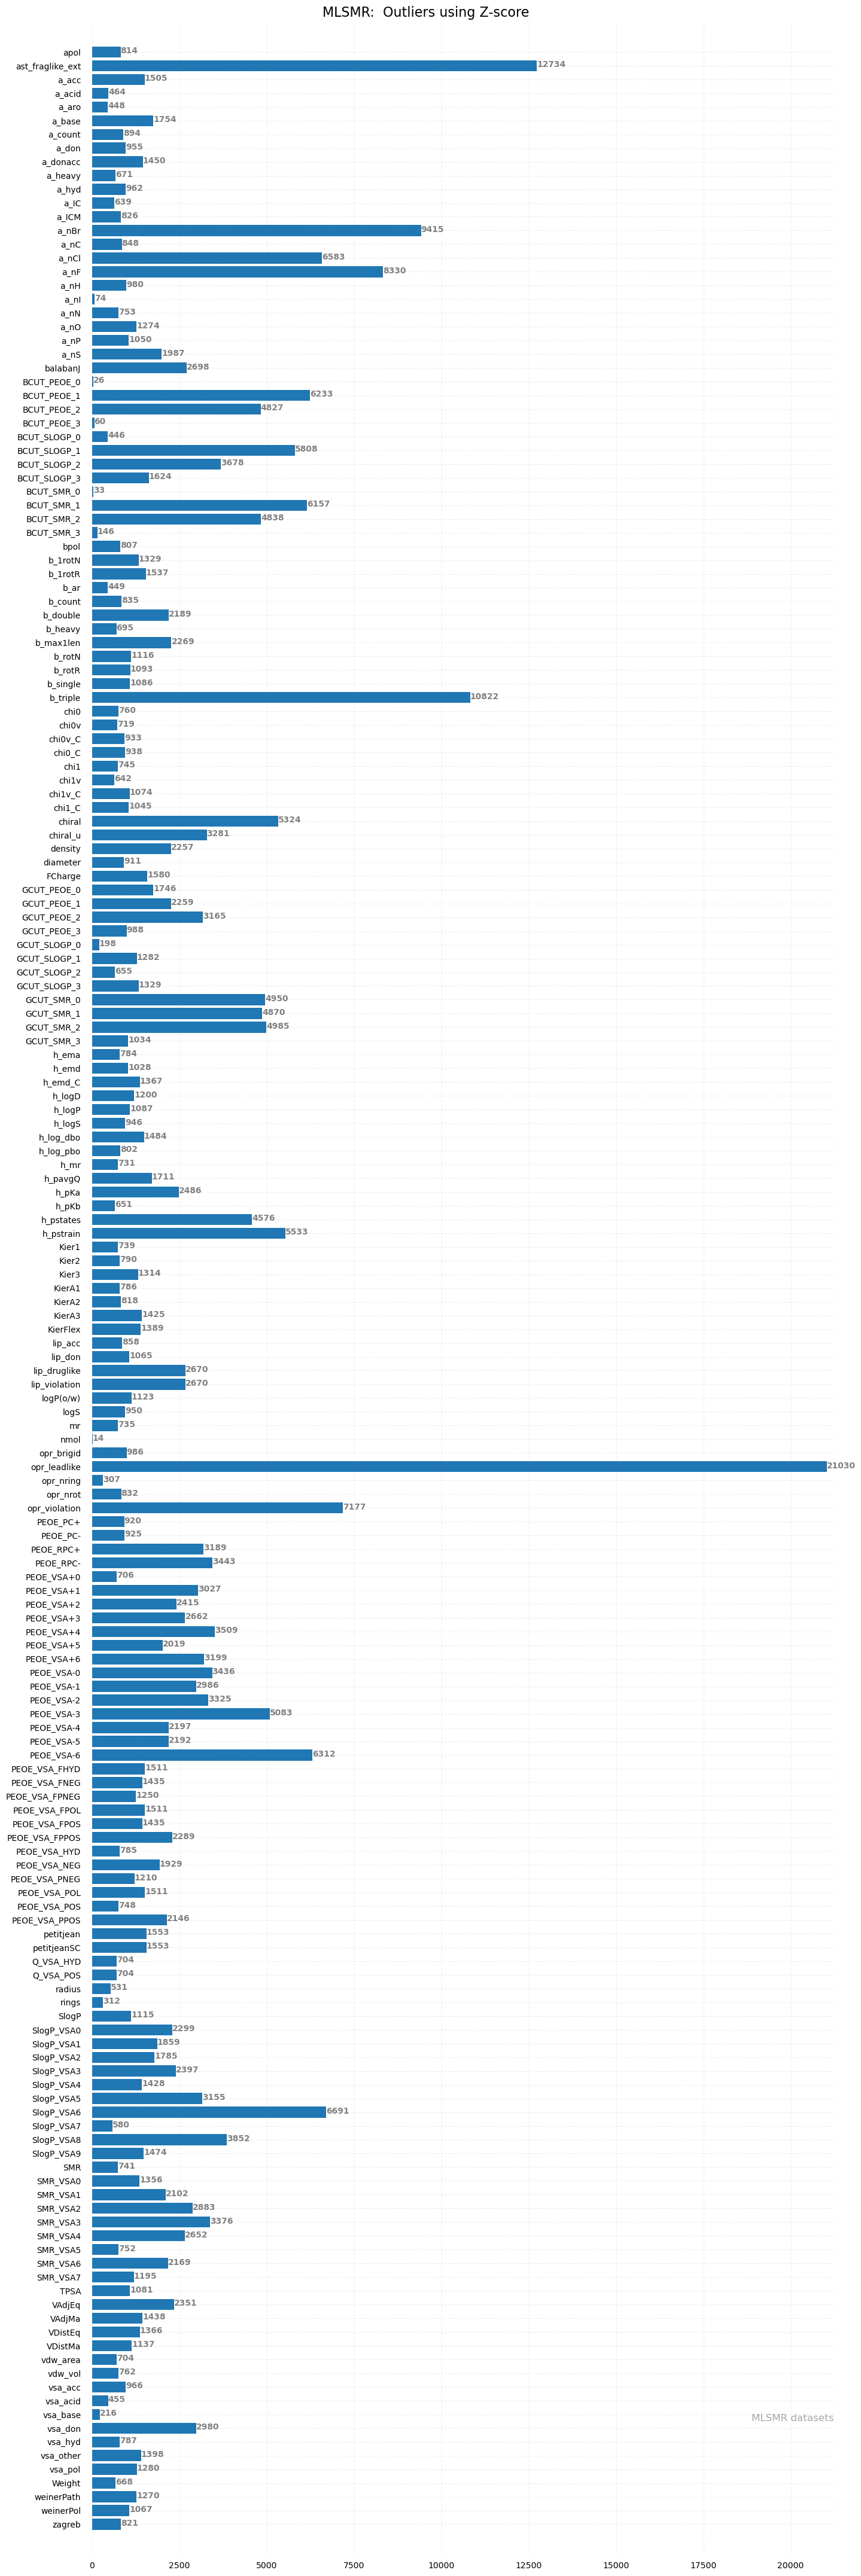

In [26]:
da.get_Outliers(dfDescriptors, 3, True, dataset)

#### 12.  Feature Distribution

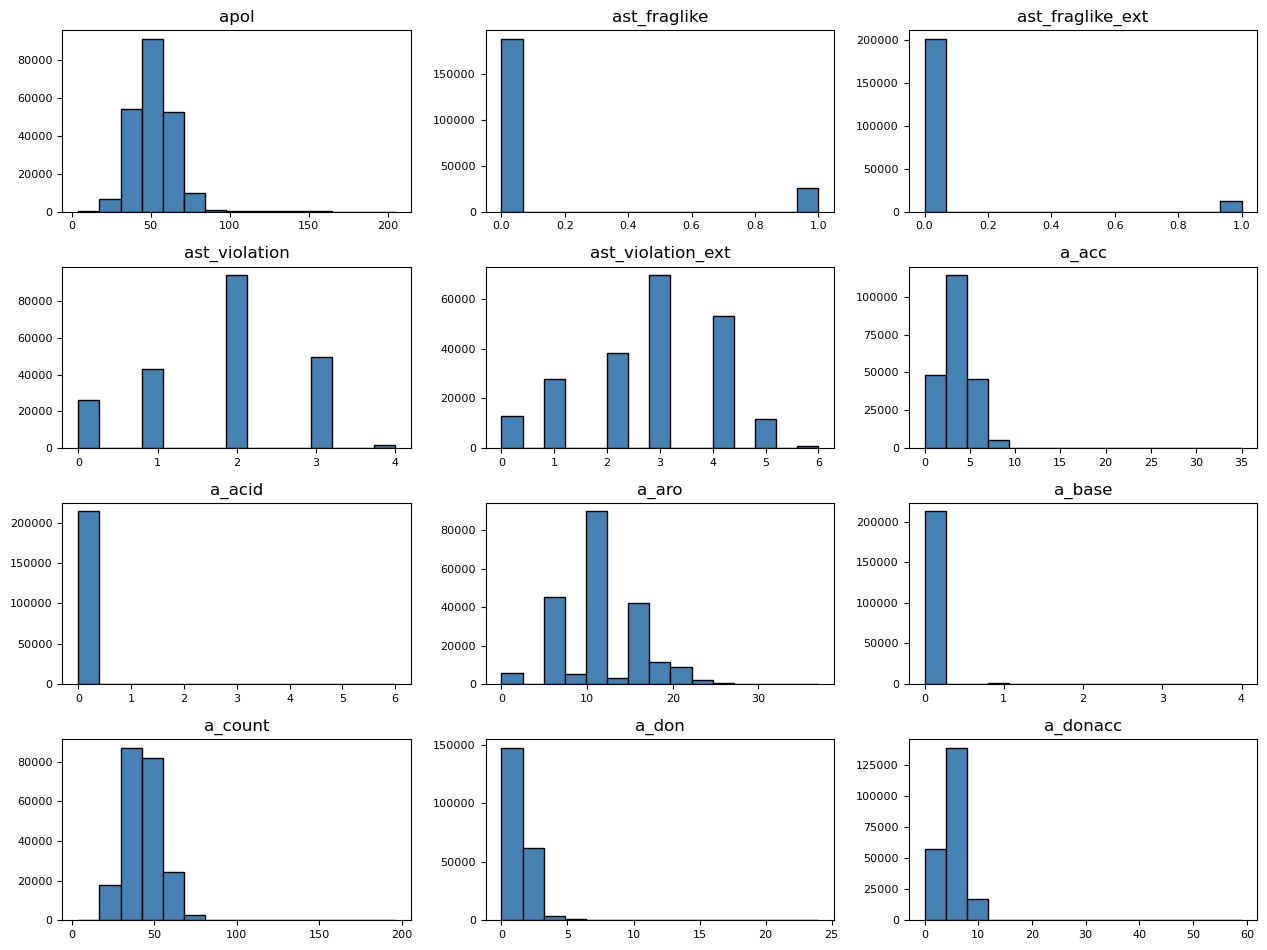

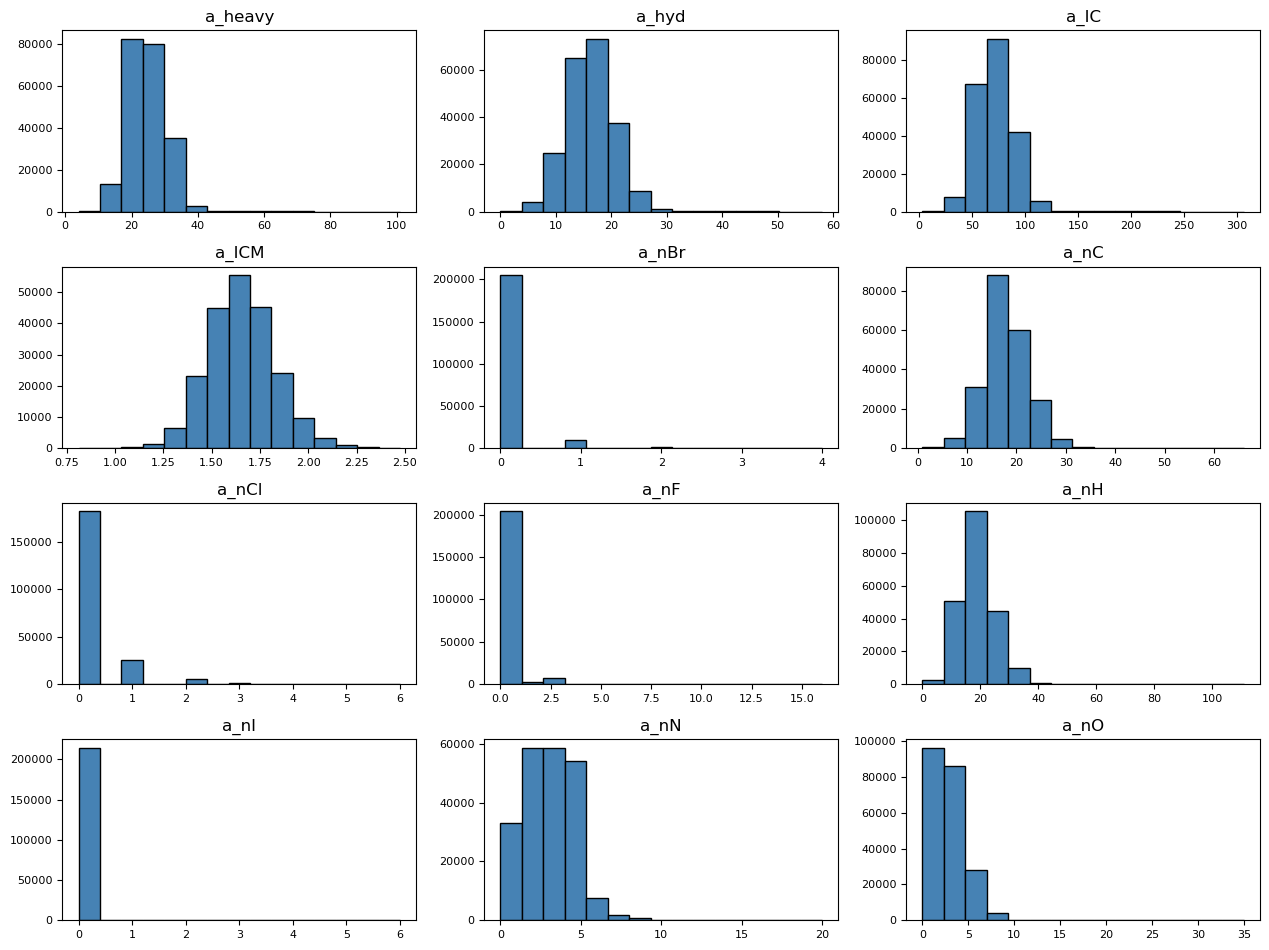

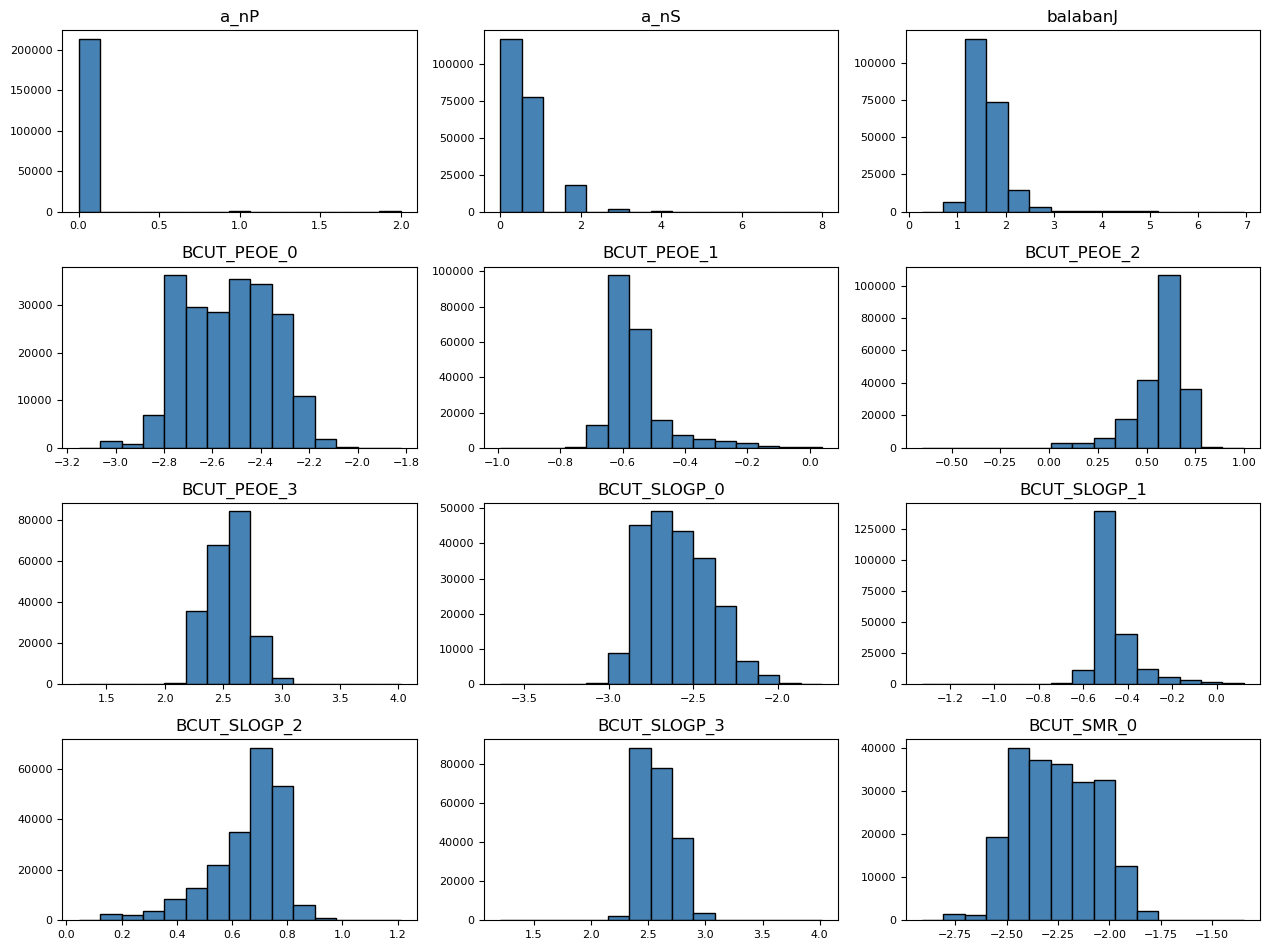

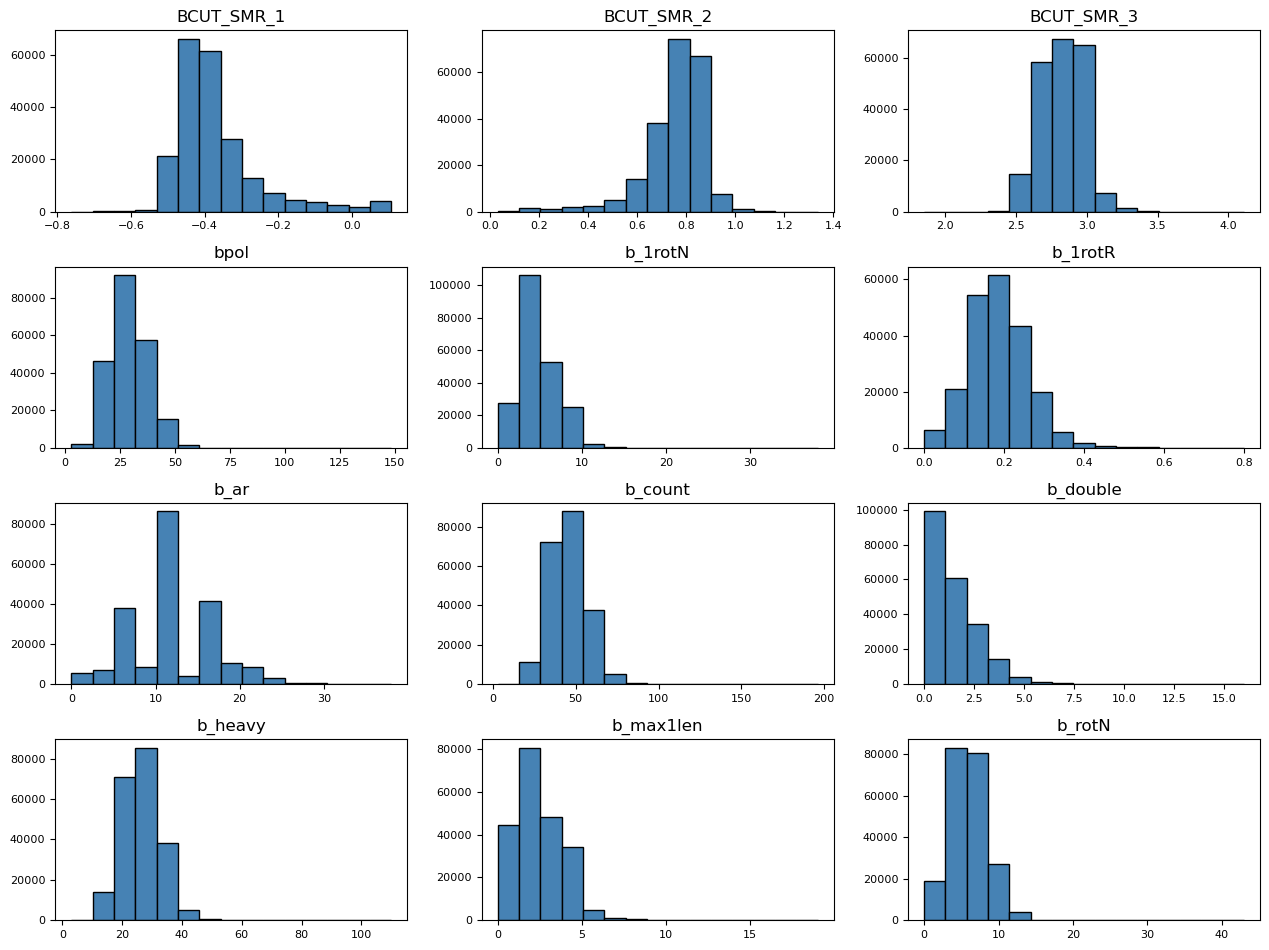

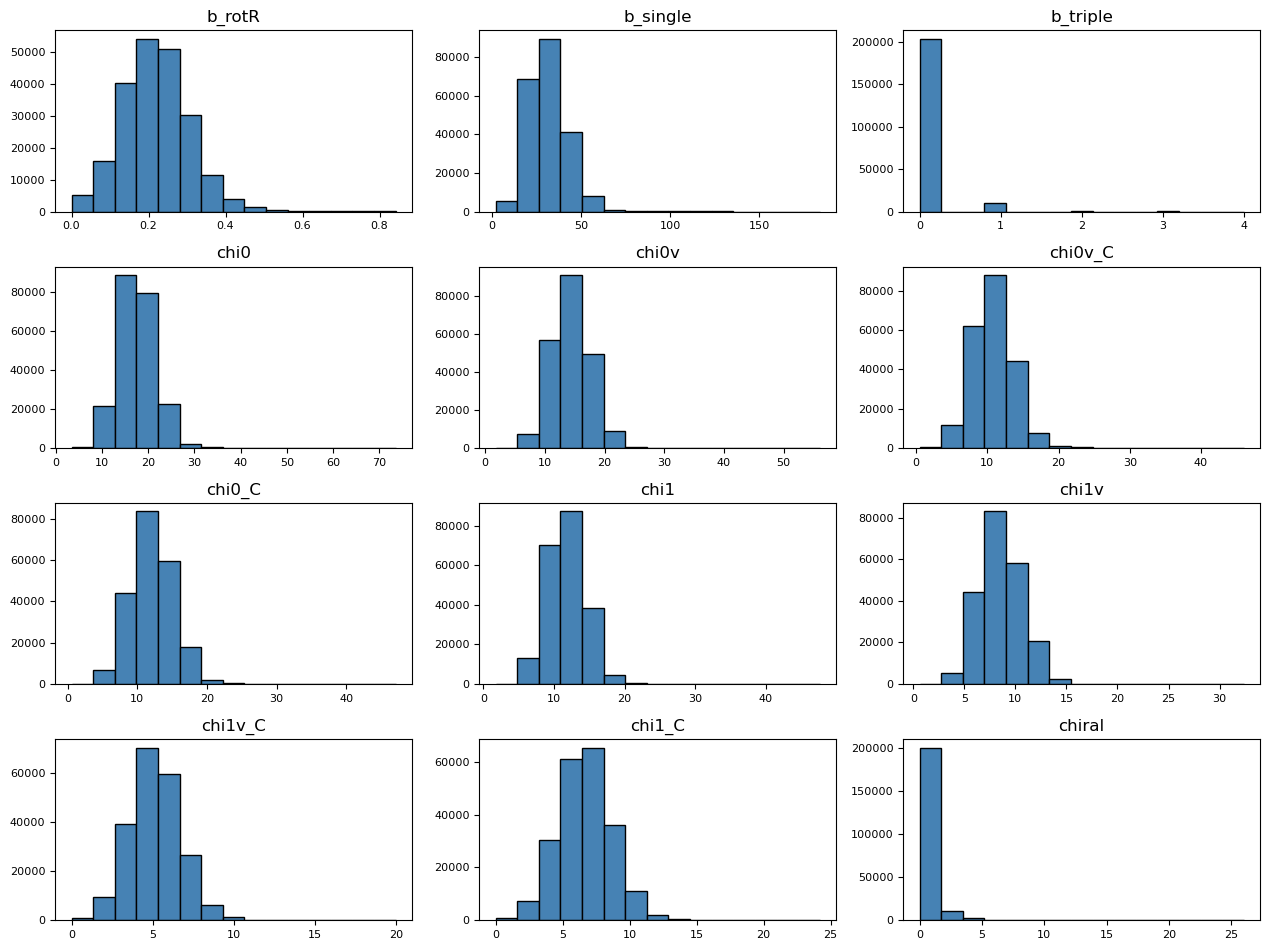

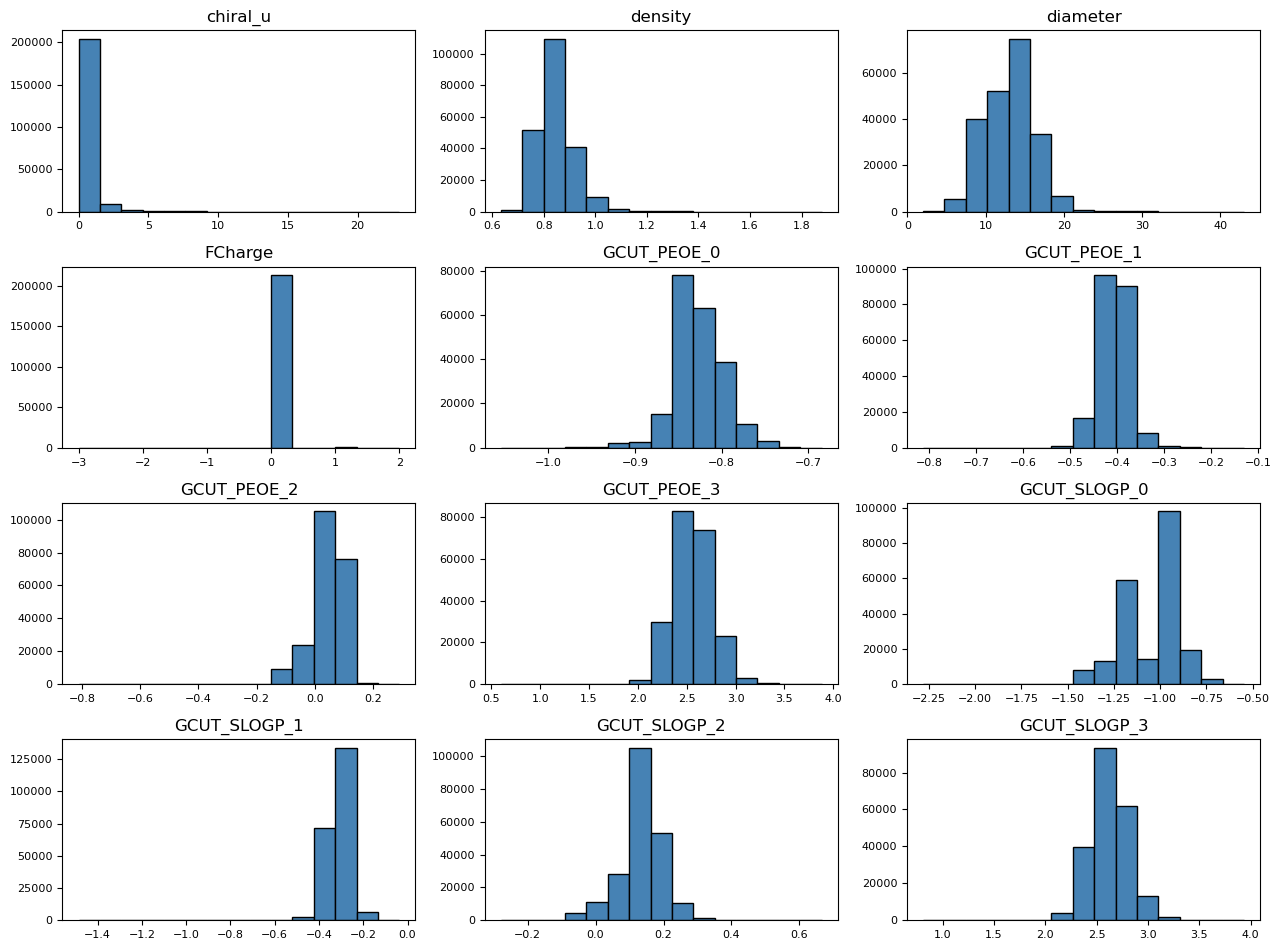

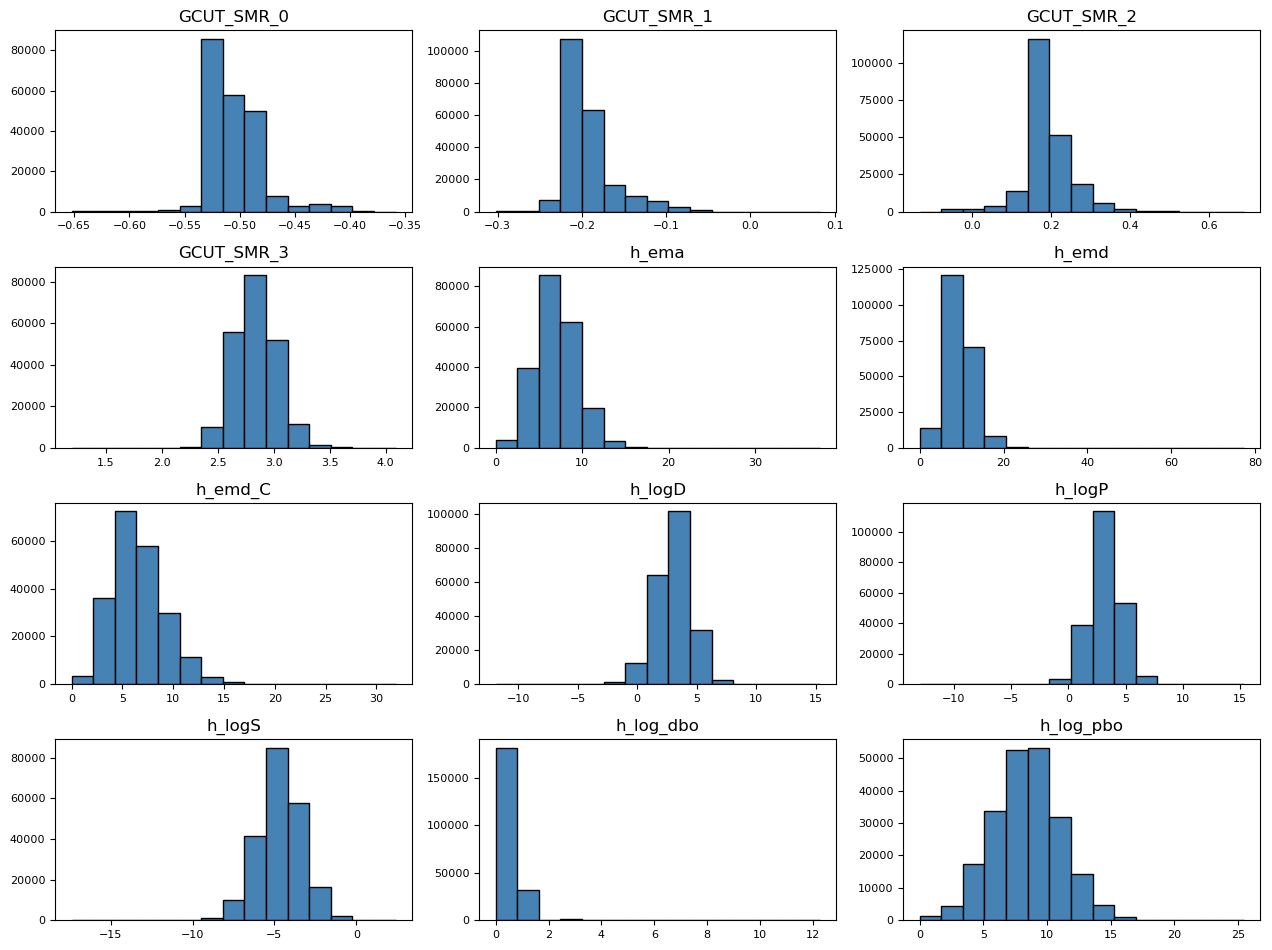

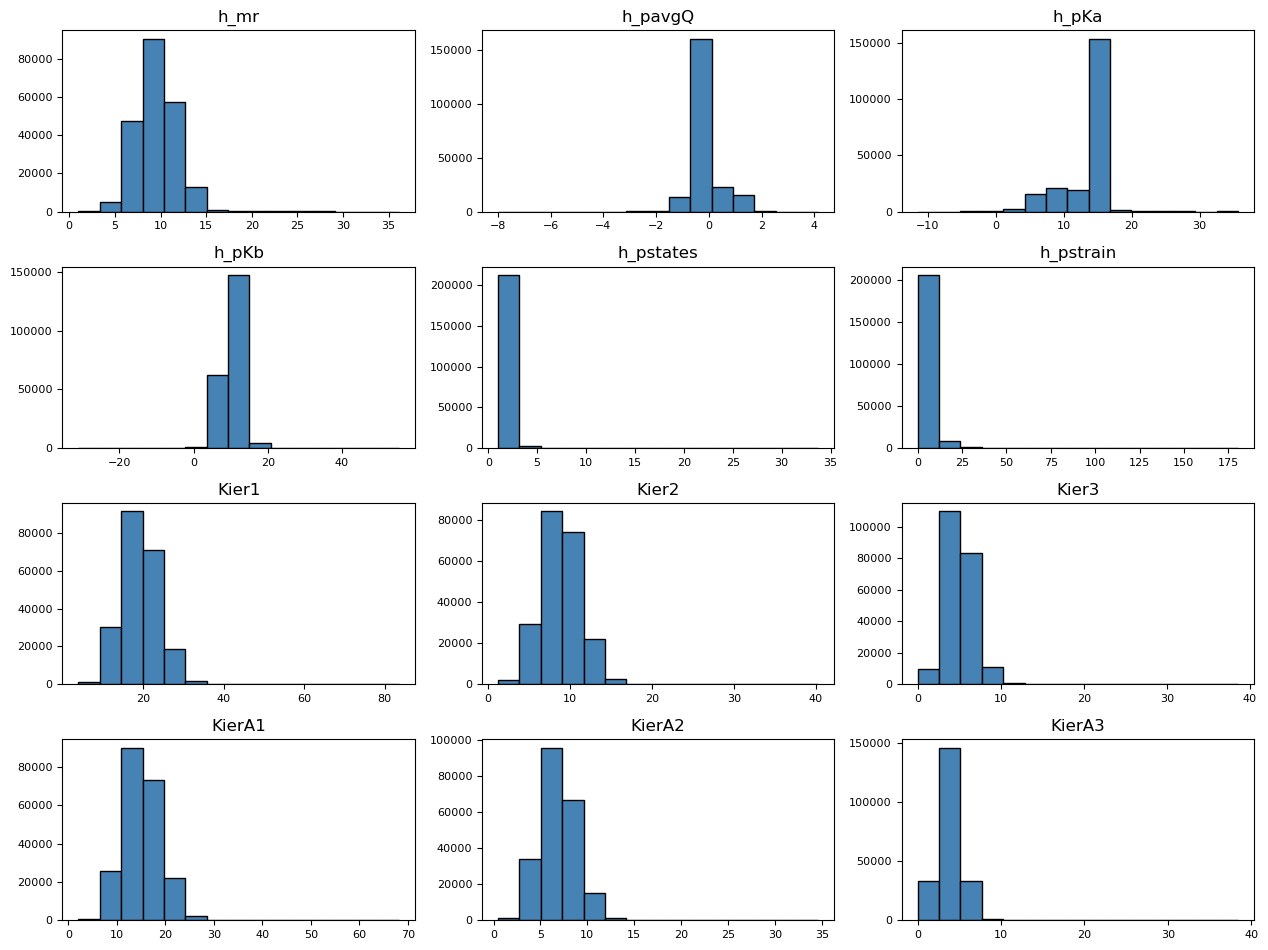

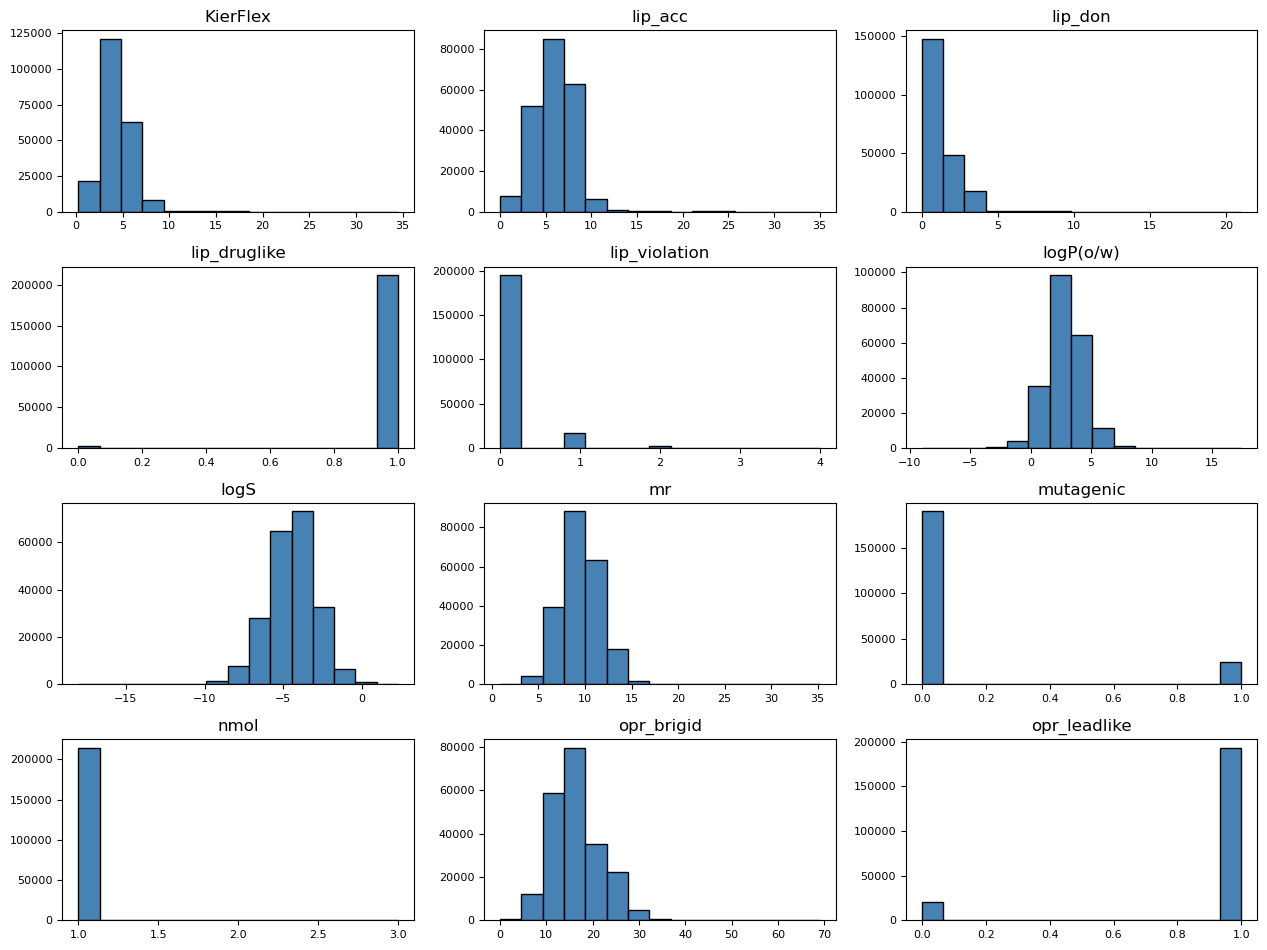

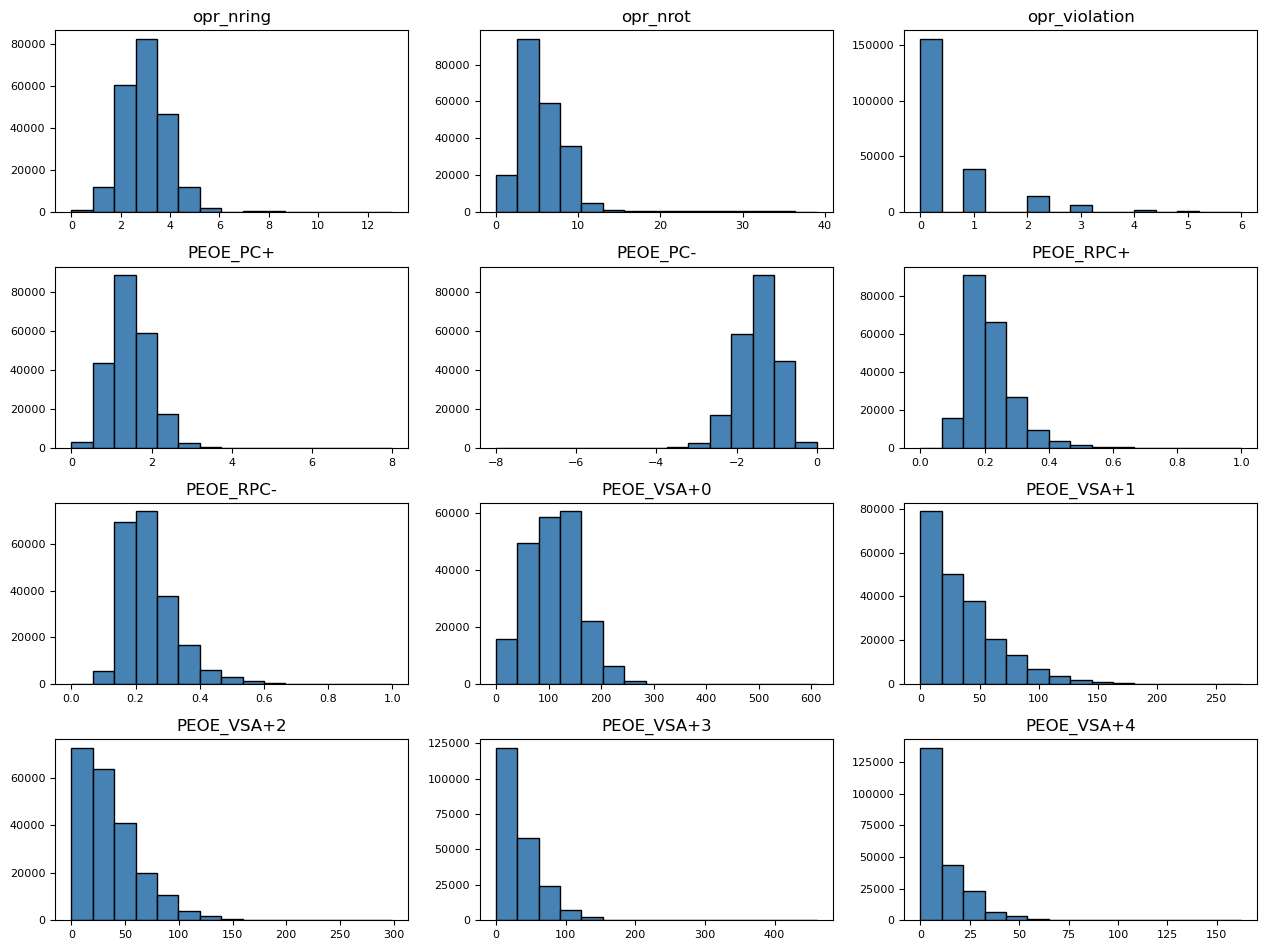

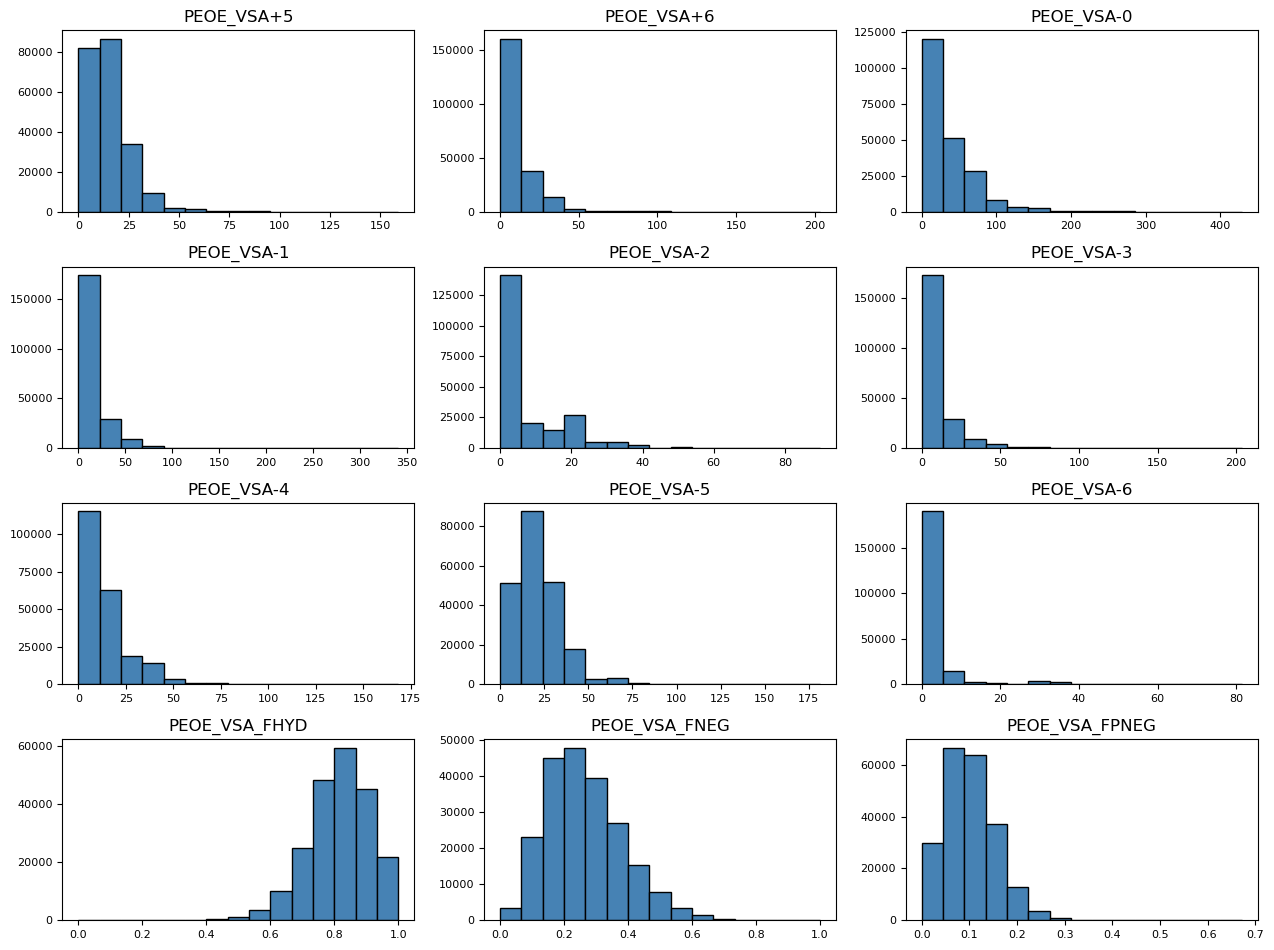

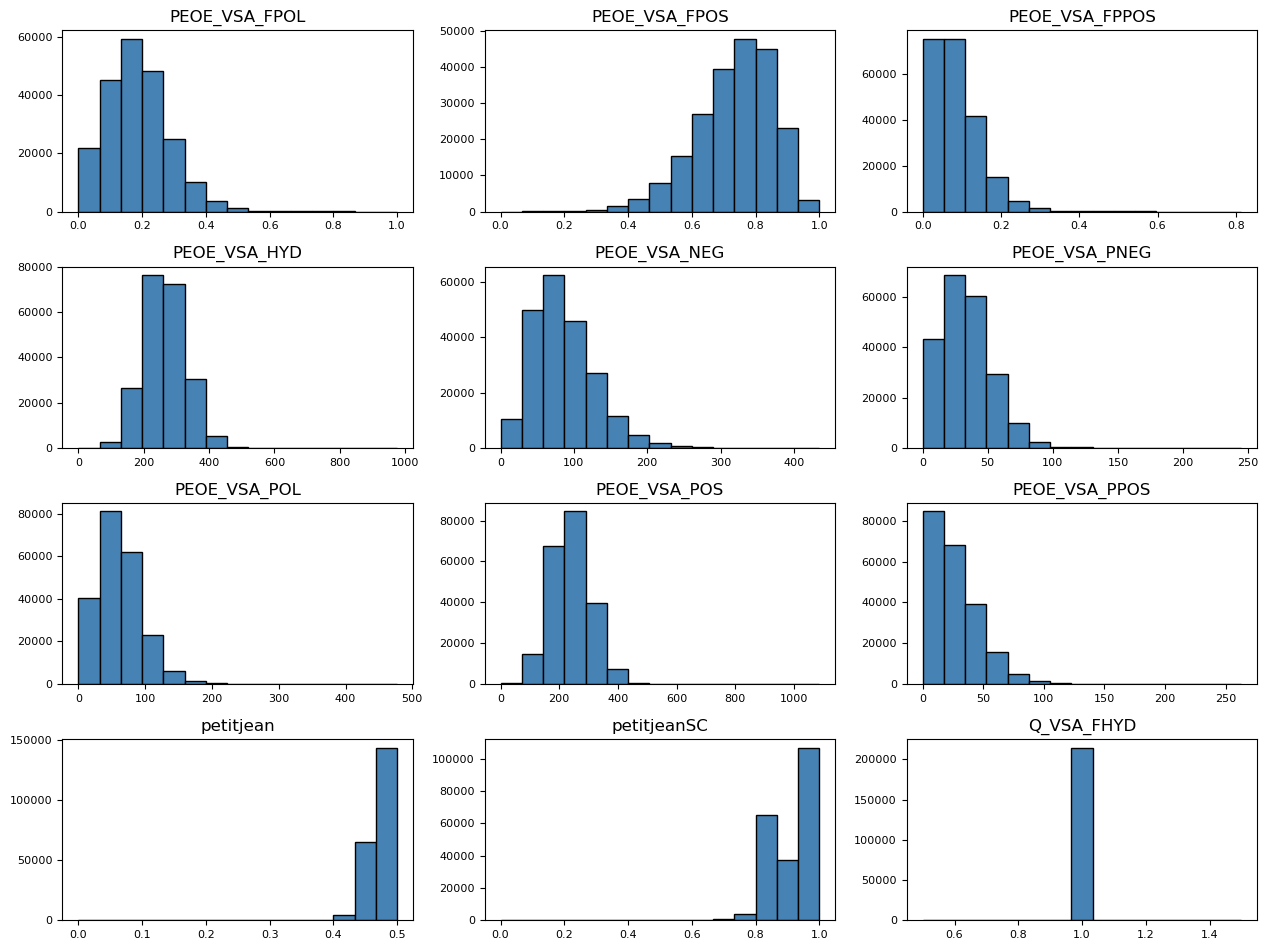

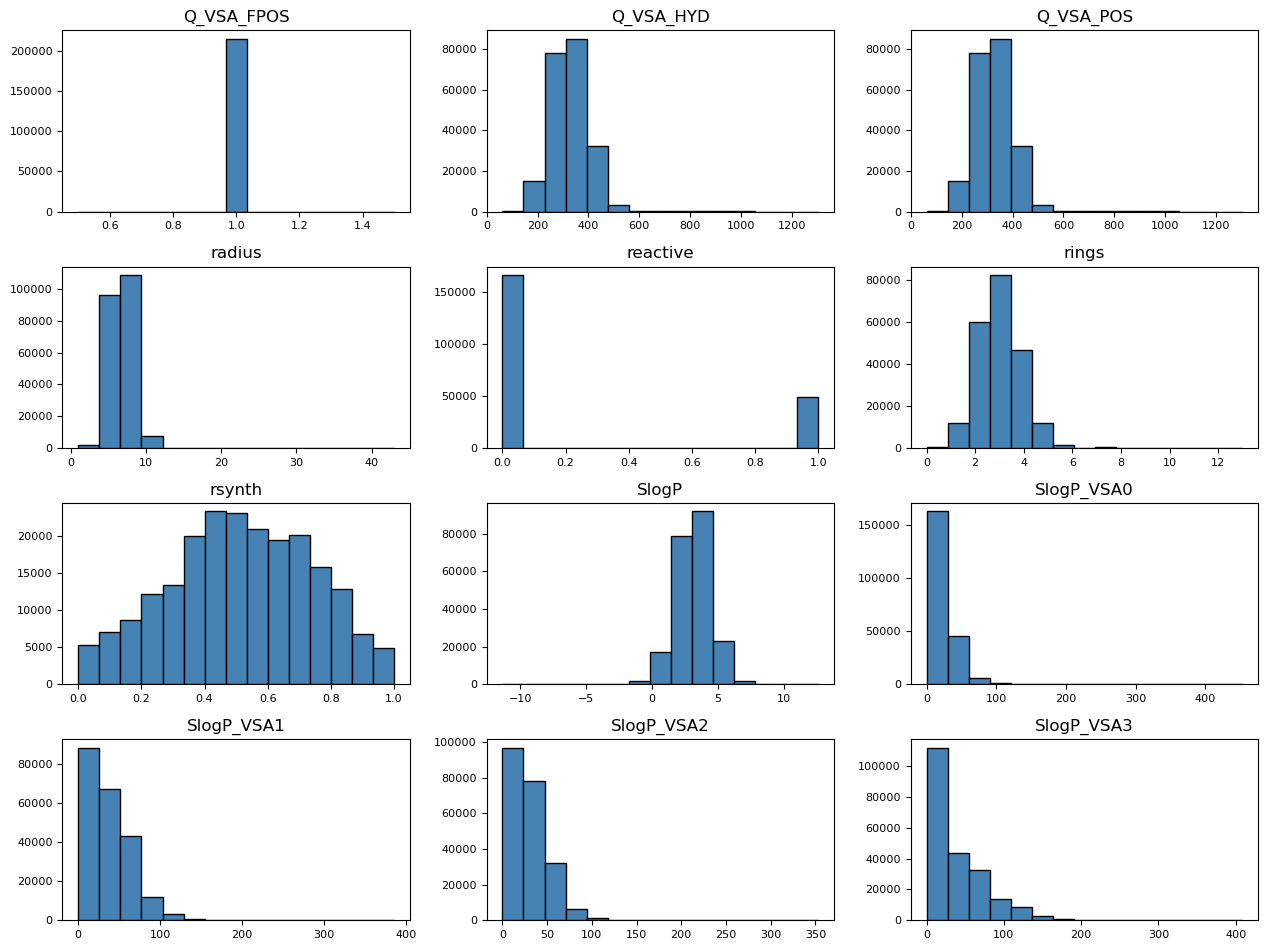

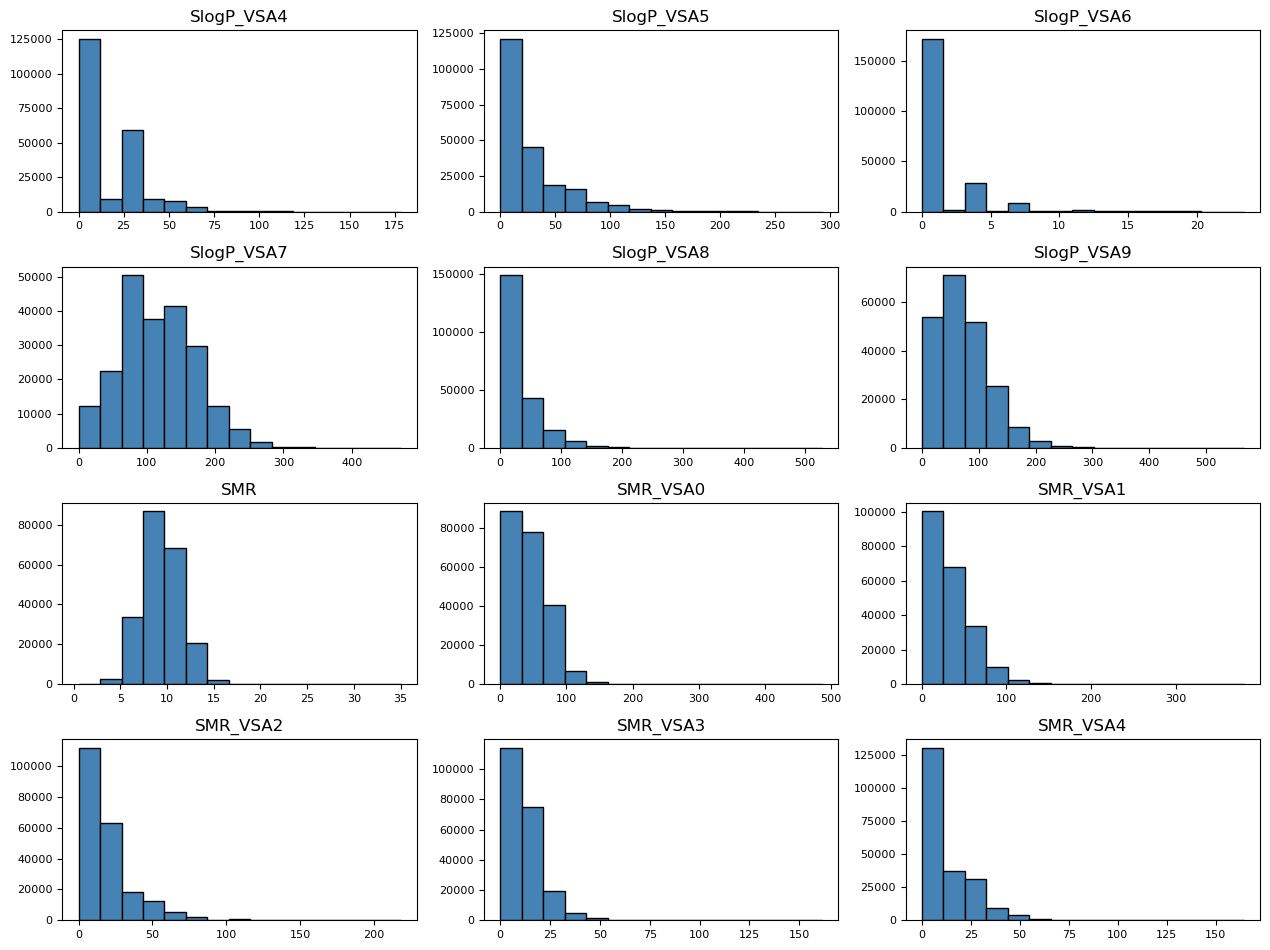

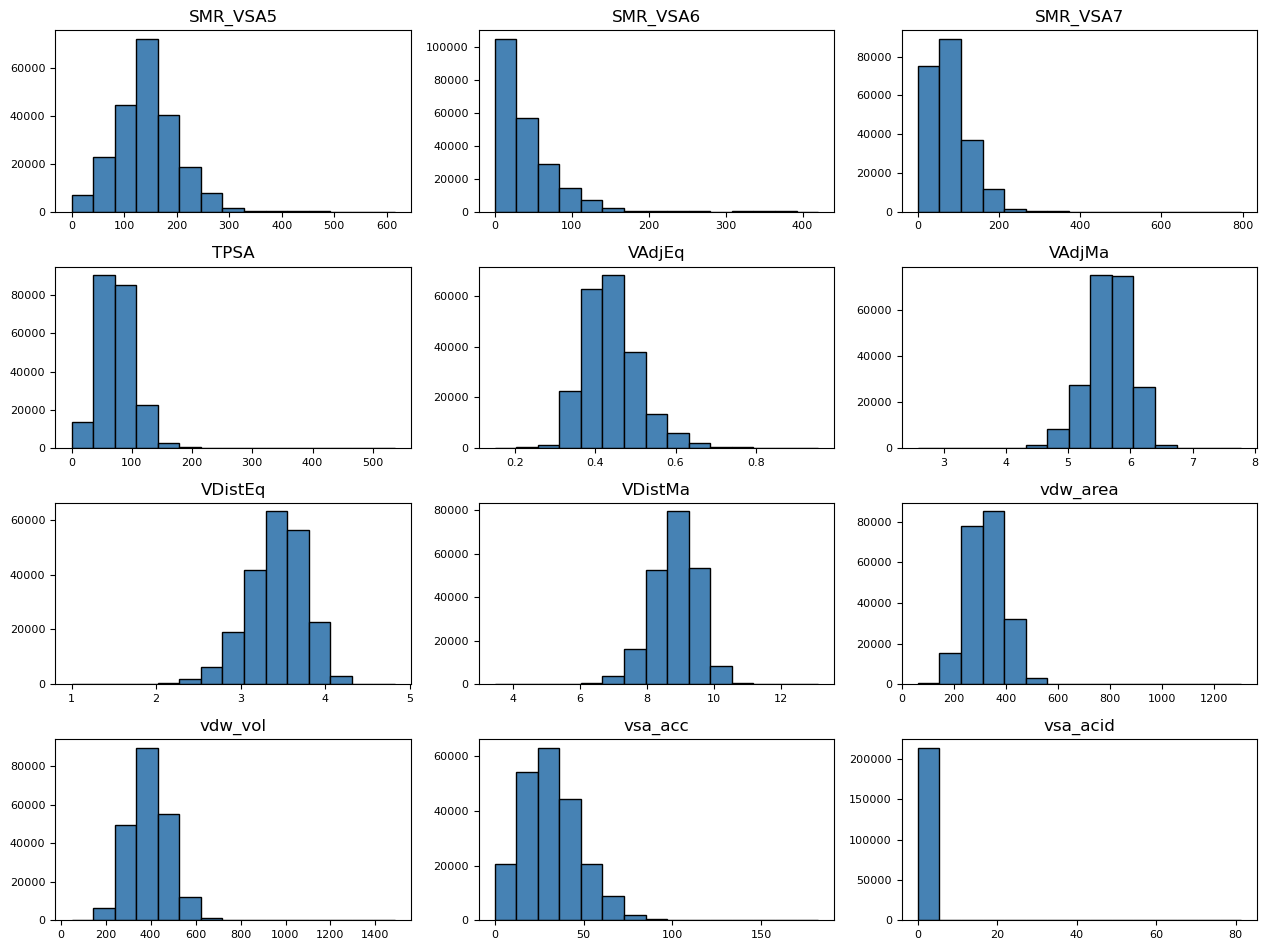

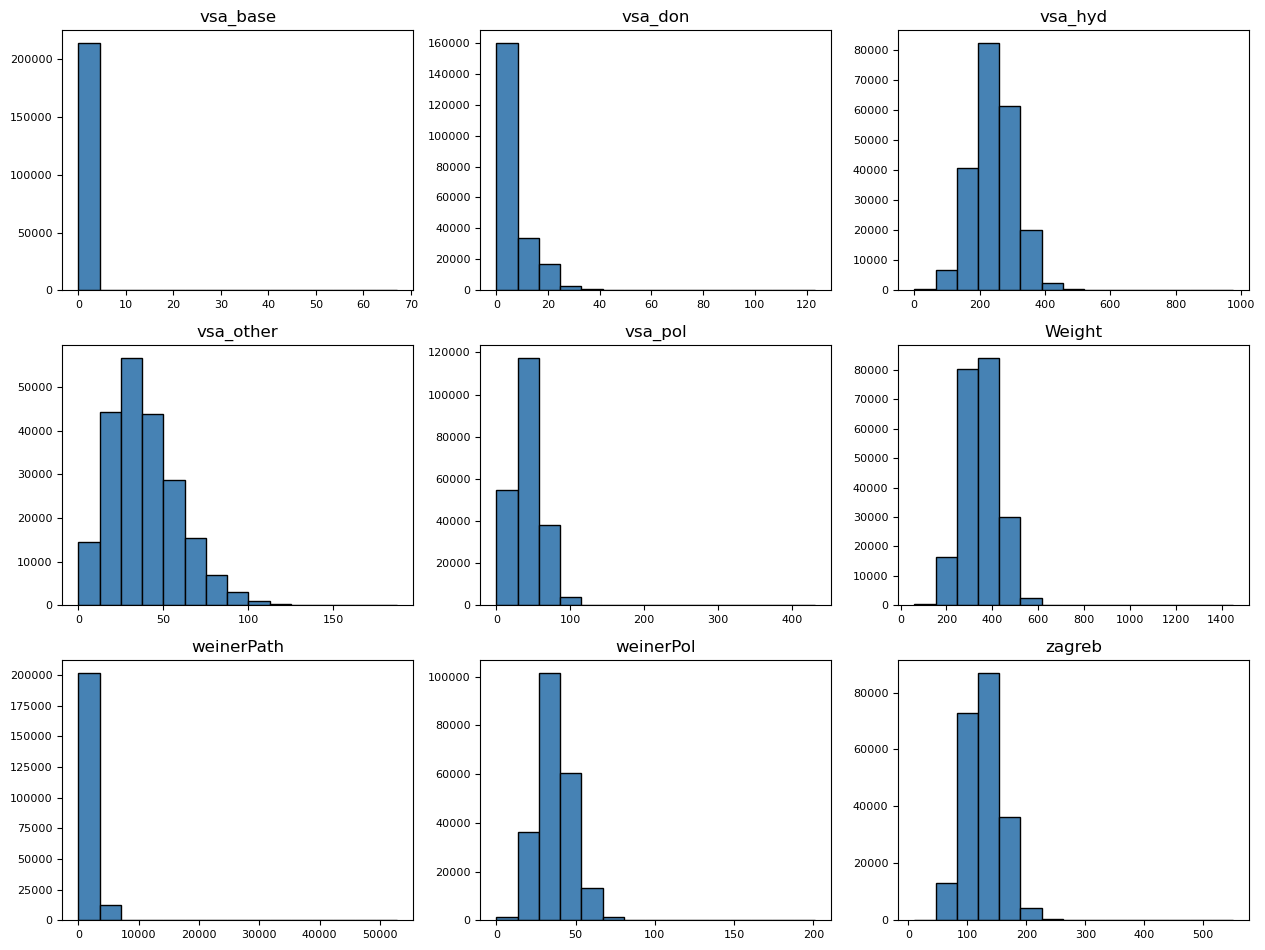

In [40]:
da.plot_FeatureDistribution(dfDescriptors)

#### 13.  Feature Selection

In [13]:
#get descriptors if you would like to continue from this part of the notebook on
GetDescriptors = False
if GetDescriptors:
    dfDescriptors = pd.read_csv(f"{data_path}Descriptors{suffix}.csv", dtype={'strippedSalts': object}, index_col=0)

In [14]:
featuresCount = dfDescriptors.shape[1]

#Variance threshold applied to unscaled data 
#---------------------------------------------------------------------------------------
#drop features with a variance threshold of 0.2
vtFeatures, vtDroppedFeatures = da.apply_VarianceThreshold(dfDescriptors, 0.2, True, 'Variance Threshold')

#Drop features that are correlated 
#---------------------------------------------------------------------------------------
#drop features that are correlated
corrVTFeatures, corrVTDroppedFeatures = da.apply_Correlation(vtFeatures, 0.9, True, 'Correlated')
corrVTFeatures.to_csv(f'{data_path}{filename_descriptors_vtcorr}')


Variance Threshold Feature count
------------------------------------------------
Original count: 189
Count after VT applied: 128
Droped features:  61
['ast_fraglike', 'ast_fraglike_ext', 'a_acid', 'a_base', 'a_ICM', 'a_nBr', 'a_nI', 'a_nP', 'balabanJ', 'BCUT_PEOE_0', 'BCUT_PEOE_1', 'BCUT_PEOE_2', 'BCUT_PEOE_3', 'BCUT_SLOGP_0', 'BCUT_SLOGP_1', 'BCUT_SLOGP_2', 'BCUT_SLOGP_3', 'BCUT_SMR_0', 'BCUT_SMR_1', 'BCUT_SMR_2', 'BCUT_SMR_3', 'b_1rotR', 'b_rotR', 'b_triple', 'density', 'FCharge', 'GCUT_PEOE_0', 'GCUT_PEOE_1', 'GCUT_PEOE_2', 'GCUT_PEOE_3', 'GCUT_SLOGP_0', 'GCUT_SLOGP_1', 'GCUT_SLOGP_2', 'GCUT_SLOGP_3', 'GCUT_SMR_0', 'GCUT_SMR_1', 'GCUT_SMR_2', 'GCUT_SMR_3', 'h_pavgQ', 'lip_druglike', 'lip_violation', 'mutagenic', 'nmol', 'opr_leadlike', 'PEOE_RPC+', 'PEOE_RPC-', 'PEOE_VSA_FHYD', 'PEOE_VSA_FNEG', 'PEOE_VSA_FPNEG', 'PEOE_VSA_FPOL', 'PEOE_VSA_FPOS', 'PEOE_VSA_FPPOS', 'petitjean', 'petitjeanSC', 'Q_VSA_FHYD', 'Q_VSA_FPOS', 'reactive', 'rsynth', 'VAdjEq', 'VAdjMa', 'VDistEq']

Correlate

#### 14.  Feature Scaling

In [16]:
#scale the data and save the scaler
data_scaled = scaler_std.fit_transform(corrVTFeatures)
joblib.dump(scaler_std, f'{data_path}{filename_scaler}{suffix}.csv')

#convert array back to DataFrame, add column names, and save scaled data
data_features = pd.DataFrame(data_scaled, columns=corrVTFeatures.columns)
data_features.to_csv(f'{data_path}{filename_descriptors_scaled}{suffix}.csv')

#### 15.  Load Data:  Molecule/Feature: 

In [17]:
#get processed datasets if you would like to continue from this part of the notebook on
GetMLSMRData = False
if GetMLSMRData:
    data_features = pd.read_csv(f'{data_path}{filename_descriptors_scaled}{suffix}.csv', index_col=0)
    data_y = pd.read_csv(f"{data_path}y{suffix}.csv", index_col=0)
    data_Molecules = pd.read_csv(f"{data_path}Molecules{suffix}.csv", index_col=0) 

#### 16.  Create Train/Test Splits

In [5]:
# set filenames
filenames_splitdata = score.get_trainsplits_filenames(data_path, suffix, includeCV=False)

#CreateSplits = True:  if first time, split the data once and saved the split
#CreateSplits = False:  data has been split & saved.  use the same split for baseline performance analysis, training, and future hyperparameter optimization
CreateSplits = False
if CreateSplits:
    x_train, y_train, x_test, y_test = score.create_trainsplits(data_features, data_y, col_active, testsize1, testsize2, randomstate=RANDOMSTATE, filenames=filenames_splitdata)
else:
    x_train, y_train, x_test, y_test = score.get_trainsplits(filenames_splitdata, col_NonDescriptors_legacycode)

#### 17.  RF Baseline Performance

##### &nbsp;&nbsp;&nbsp; 17.1 - Variables

In [51]:
models = ['crf', 'wrf', 'rfbs', 'rfu', 'rfee']
train = [False, False, False, False,  False]

classifiers = ['RandomForest', 'RandomForest', 'RandomForest', 'BalancedRandomForest', 'EasyEnsemble']
titles = [f'MLSMR Baseline: Classic RF', f'MLSMR Baseline: Weighted RF', f'MLSMR Baseline: RF Balanced Subsample'
    , f'MLSMR Baseline: RF Undersampling', f'MLSMR Baseline: Easy Ensemble']
groups = [f'Classic', f'Weighted', f'Balanced Subsample', f'Undersampling', f'Easy Ensemble']


params_classic = {'n_estimators': 200, 
        'min_samples_leaf': 75, 
        'random_state': RANDOMSTATE, 
        'oob_score': True, 
        'max_depth': 5,
        'max_features': None,
        'n_jobs': -1}

params_wrf = {'n_estimators': 200, 
        'min_samples_leaf': 75, 
        'random_state': RANDOMSTATE, 
        'oob_score': True, 
        'max_depth': 5, 
        'max_features': None,
        'n_jobs': -1,
        'class_weight': {0:1,1:100}}

params_rfbs = {'n_estimators': 200, 
        'min_samples_leaf': 75, 
        'random_state': RANDOMSTATE, 
        'oob_score': True, 
        'max_depth': 5,
        'max_features': None, 
        'n_jobs': -1,
        'class_weight': 'balanced_subsample'}

params_rfu = {'n_estimators': 200, 
        'min_samples_leaf': 75, 
        'random_state': RANDOMSTATE, 
        'oob_score': True, 
        'max_depth': 5,
        'max_features': None, 
        'n_jobs': -1,
        'sampling_strategy': 0.2,
        'class_weight': 'balanced_subsample'}

params_rfee = {'n_estimators': 200, 
        'random_state': RANDOMSTATE, 
        'n_jobs': -1}

params_models = [params_classic, params_wrf, params_rfbs, params_rfu, params_rfee]

data_training = {'x_train': x_train, 
        'y_train': y_train, 
        'x_test': x_test,
        'y_test': y_test}

##### &nbsp;&nbsp;&nbsp; 17.2 - Train Baseline Models

In [52]:
# train baseline models and make predictions
params_train = {'models': models,
    'classifiers': classifiers,
    'train': train, 
    'titles': titles, 
    'groups': groups, 
    'model_parameters': params_models,
    'path_model': model_path,
    'path_data': data_path, 
    'path_image': image_path,
    'baseline': True, 
    'suffix': suffix,
    'data_training': data_training,
    'dfScores': dfScores}

dfScores = score.train_models(**params_train)
dfScores.to_csv(f'{data_path}{filename_model_metrics}{suffix}.csv')

#####  &nbsp;&nbsp;&nbsp;  17.3 - Baseline Performance Model Comparison

In [33]:
GetScores = False
if GetScores:
    dfScores = pd.read_csv(f'{data_path}{filename_model_metrics}{suffix}.csv', index_col=0)

score.dataset_counts(x_train, y_train, x_test, y_test)

Count      Training Dataset    Test Dataset    Total
---------  ------------------  --------------  -------
Molecules  171604              42902           214506
Actives    3102                776             3878
Inactives  168502              42126           210628
% Active   1.8077%             1.8088%         1.8412%


In [53]:
dfScores_style = dfScores.copy()
dfScores_style.sort_values(by=['Group'])

imgfilename = f'{image_path}{filename_img_metrics_baseline}{suffix}'
title = f'{dataset}:  RF Baseline Performance'
hide = ['Group']
score.get_ClassifierScores(dfScores_style, title, imgfilename, hide=hide, top=3)

c:\Users\frogi\anaconda3\envs\tb\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


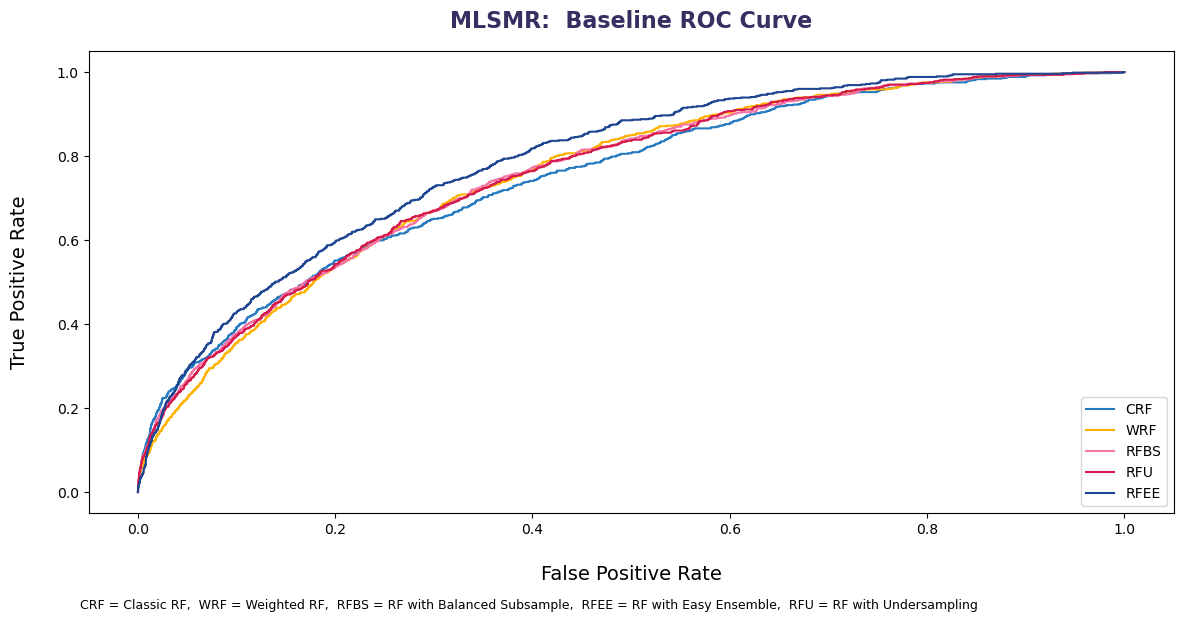

In [54]:
# get auc data and plot
path = f'{data_path}@model/{dir_AUC}/'
df = score.get_auc_data(path, models, xy_AUC, suffix=suffix, baseline=True)

imgfilename = f'{image_path}{filename_img_auc_baseline}{suffix}'
title = f'{dataset}:  Baseline ROC Curve'
score.plot_auc_curve_comparison(df, title, imgfilename, footnote=footnote_models)

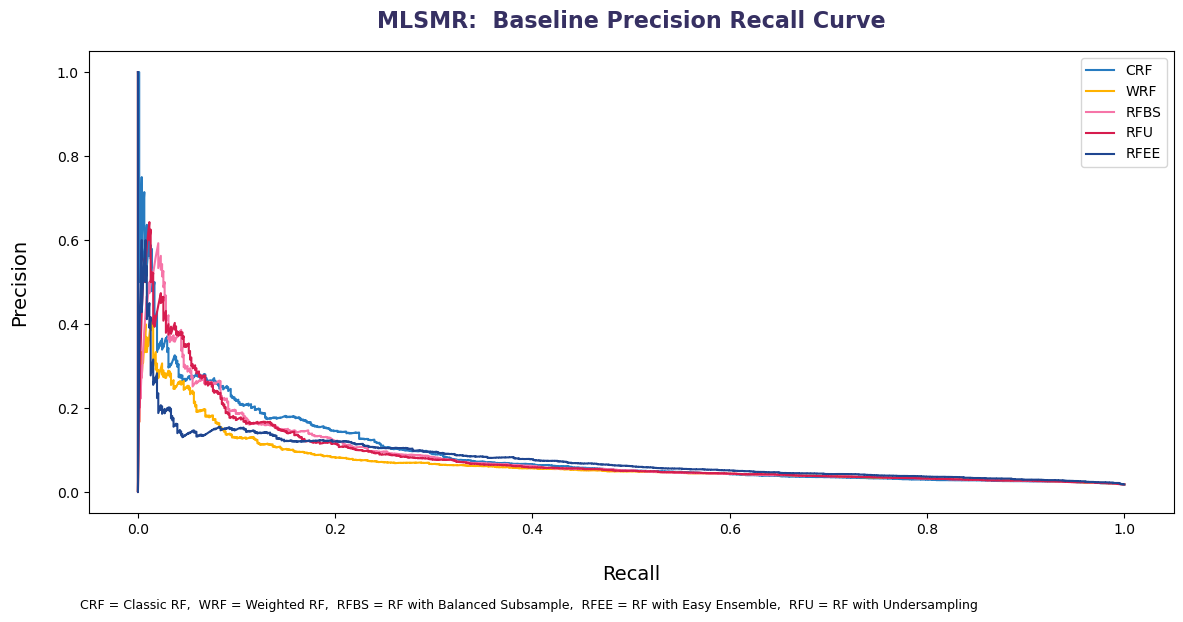

In [55]:
# get precision/recall data and plot
path = f'{data_path}@model/{dir_PrecisionRecall}/'
df = score.get_auc_data(path, models, xy_PrecisionRecall, suffix=suffix, baseline=True)

imgfilename = f'{image_path}{filename_img_pr_baseline}{suffix}'
title = f'{dataset}:  Baseline Precision Recall Curve'
score.plot_recall_curve_comparison(df, title, imgfilename, footnote=footnote_models)

#### 18.  Hyperparameter Optimization

The following scripts were run in parallel on the cluster, once for optimization of the two scores:  balanced accuracy and f1.  Early on during discovery, it was observed that randomized search yielded higher scores than hyperopt, thus the decision to move forward with randomized search instead of hyperopt.  After hyperparameter optimization, the script instantiates a new model with the determined best parameters, trains the model, and saves it for future use (i.e. in the Scoring Model section below)

- optimize-RandomizedSearch-RF-BalancedSubsample.py
- optimize-RandomizedSearch-RF-Classic.py
- optimize-RandomizedSearch-RF-EasyEnsemble.py
- optimize-RandomizedSearch-RF-Undersample.py
- optimize-RandomizedSearch-RF-Weighted.py

#### 19.  Model Evalution

##### &nbsp;&nbsp;&nbsp; 19.1  Load splits with smiles/inhibition

In [4]:
# set filenames
filenames_splitdata = score.get_trainsplits_filenames(data_path, suffix, includeCV=False)

# get splits, with smiles and inhibition for visualization
x_train, y_train, x_test, y_test = score.get_trainsplits(filenames_splitdata)

#remove inhibition and SMILES columns
x_train = x_train.drop(col_NonDescriptors_legacycode, axis=1)
x_test = x_test.drop(col_NonDescriptors_legacycode, axis=1)

#####  &nbsp;&nbsp;&nbsp; 19.2  Load prior scoring results

In [5]:
GetScores = True
if GetScores:
    dfScores = pd.read_csv(f'{data_path}{filename_model_metrics}{suffix}.csv', index_col=0)
dfScores = dfScores.sort_index()

GetFeatureImporance = False
if GetFeatureImporance:
    dfFeatureImportance = pd.read_csv(f'{data_path}{filename_model_featureimportance}{suffix}.csv', index_col=0)
else:
    dfFeatureImportance = pd.DataFrame()

GetHyperparameters = False
if GetHyperparameters:
    dfHyperparameters = pd.read_csv(f'{data_path}{filename_model_hyperparameter}{suffix}.csv', index_col=0)
else:
    dfHyperparameters = pd.DataFrame()

##### &nbsp;&nbsp;&nbsp; 19.3 Variables 

In [6]:
models = ['crf', 'wrf', 'rfbs', 'rfu', 'rfee']
metrics=['balanced_accuracy', 'f1']
predict = [False, False, False, False, False]
saveFeatureImportance = [True, True, True, True, False]
saveHyperparameters = [True, True, True, True, False]
saveDecisionTree = [True, True, True, True, False]

titles = [f'MLSMR: Classic RF Hyperparameter Optimization', f'MLSMR: Weighted RF Hyperparameter Optimization Performance'
    , f'MLSMR: RF Balanced Subsample Hyperparameter Optimization Performance'
    , f'MLSMR: RF Undersampling Hyperparameter Optimization Performance'
    , f'MLSMR: Easy Ensemble Hyperparameter Optimization Performance']
groups = [f'Classic', f'Weighted', f'Balanced Subsample', f'Undersampling', f'Easy Ensemble']

data_scoring = {'x_test': x_test,
        'y_test': y_test}

featureImportance_th = 0.90

##### &nbsp;&nbsp;&nbsp; 19.4 Score Models

In [50]:
# instantiate optimized models, score and compare
params_score = {'models': models,
    'metrics': metrics,
    'predict': predict,
    'saveFeatureImportance': saveFeatureImportance,
    'saveHyperparameters': saveHyperparameters,
    'saveDecisionTree': saveDecisionTree,
    'titles': titles, 
    'groups': groups,
    'path_model': model_path,
    'path_data': data_path, 
    'path_image': image_path, 
    'suffix': suffix,
    'data_scoring': data_scoring,
    'dfScores': dfScores,
    'dfFeatureImportance': dfFeatureImportance,
    'dfHyperparameters': dfHyperparameters}

dfScores, dfFeatureImportance, dfHyperparameters = score.score_models(**params_score)
dfScores.to_csv(f'{data_path}{filename_model_metrics}{suffix}_All.csv')
dfFeatureImportance.to_csv(f'{data_path}{filename_model_featureimportance}{suffix}.csv')
dfHyperparameters.to_csv(f'{data_path}{filename_model_hyperparameter}{suffix}.csv')


(process:27560): GLib-GIO-WARNING **: 14:19:22.813: Unexpectedly, UWP app `Microsoft.ScreenSketch_11.2309.16.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ScreenSketch_8wekyb3d8bbwe!App') supports 29 extensions but has no verbs

(process:27560): GLib-GIO-WARNING **: 14:19:22.930: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.8.3.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs


(process:23152): GLib-GIO-WARNING **: 14:19:38.843: Unexpectedly, UWP app `Microsoft.ScreenSketch_11.2309.16.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ScreenSketch_8wekyb3d8bbwe!App') supports 29 extensions but has no verbs

(process:23152): GLib-GIO-WARNING **: 14:19:38.934: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.8.3.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs


(process:12584): GLib-GIO-WARNING **: 14:19:56.648: Unexpectedly, UWP app `Microsoft.ScreenSketch_11.2309.16.0_x64__8we

In [10]:
# remove baseline results after confirming hyperparameter optimization metrics are better than baseline metrics
dfScores_trained = dfScores[~(dfScores.index.str.contains(" Baseline"))].sort_index()
dfScores_trained_styled = dfScores_trained.copy()
#dfScores_trained_styled.sort_values(by=['Group'])

imgfilename = f'{image_path}{filename_img_metrics}{suffix}'
title = f'{dataset}:  RF Performance'
hide = ['Group']
score.get_ClassifierScores(dfScores_trained_styled, title, imgfilename, hide=hide, top=3)

c:\Users\frogi\anaconda3\envs\tb\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


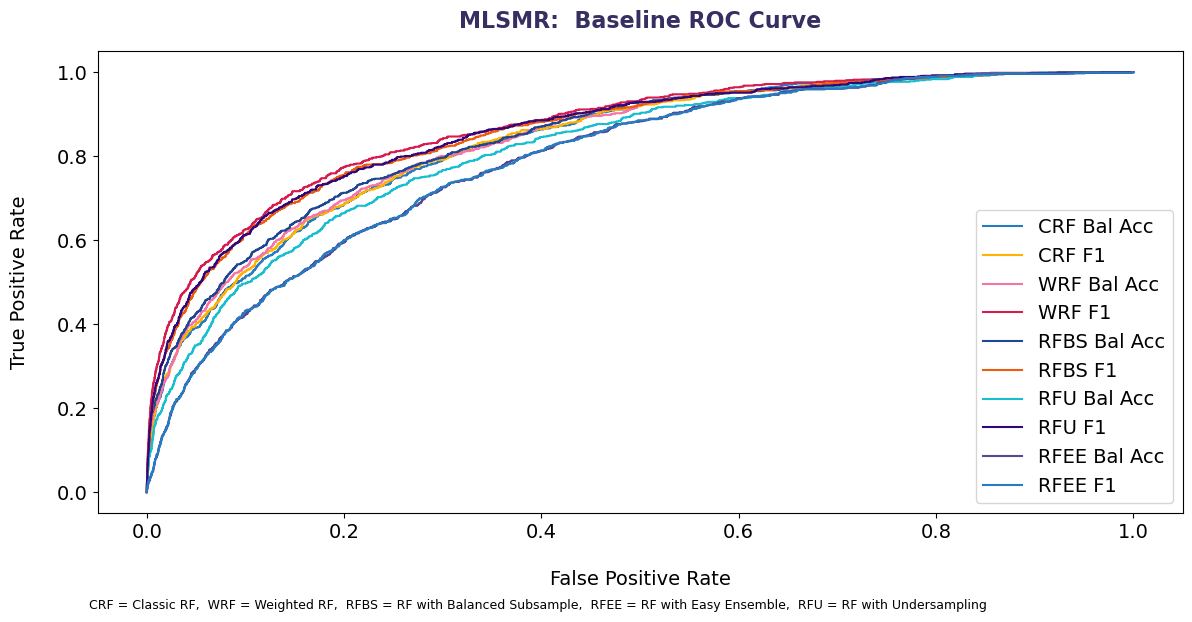

In [46]:
# get auc data and plot
path = f'{data_path}@model/{dir_AUC}/'
metrics=['balanced_accuracy', 'f1']
df = score.get_auc_data(path, models, xy_AUC, suffix=suffix, baseline=False, metrics=metrics)

imgfilename = f'{image_path}{filename_img_auc}{suffix}'
title = f'{dataset}:  Hyperparameter Optimization ROC Curve'
score.plot_auc_curve_comparison(df, title, imgfilename, footnote=footnote_models)

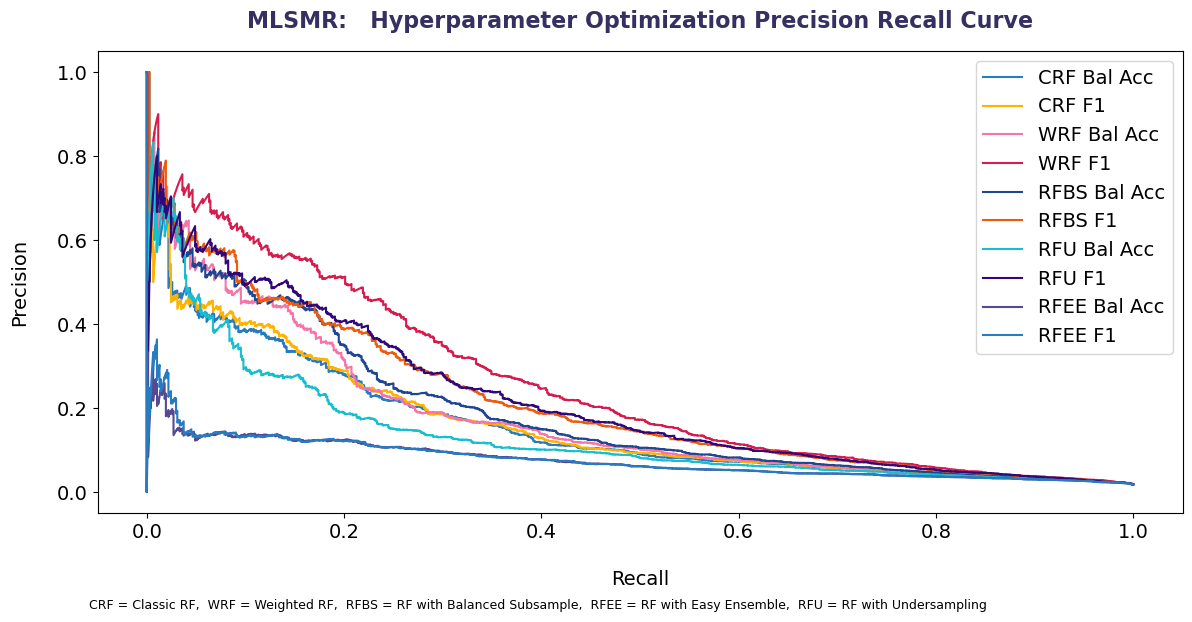

In [47]:
# get precision/recall data and plot
path = f'{data_path}@model/{dir_PrecisionRecall}/'
metrics=['balanced_accuracy', 'f1']
df = score.get_auc_data(path, models, xy_PrecisionRecall, suffix=suffix, baseline=False, metrics=metrics)

imgfilename = f'{image_path}{filename_img_pr}{suffix}'
title = f'{dataset}:   Hyperparameter Optimization Precision Recall Curve'
score.plot_recall_curve_comparison(df, title, imgfilename, footnote=footnote_models)

In [11]:
dfFeatureImportance.sort_index(axis=1, inplace=True)
dfFeatureImportance

CRF balanced_accuracy     CRF f1  RFBS balanced_accuracy     RFBS f1   \
1               logP(o/w)  logP(o/w)                    logS        logS   
2                    logS       logS               logP(o/w)     h_emd_C   
3                 h_emd_C   SMR_VSA4                SMR_VSA4   logP(o/w)   
4                   SlogP    h_emd_C                 h_emd_C    SMR_VSA4   
5                SMR_VSA4      SlogP                  h_logD      h_logD   
6               h_log_pbo      h_pKb               h_log_pbo   h_log_pbo   
7                   h_pKb  h_log_pbo                  h_logS  PEOE_VSA+3   
8                  h_logD     h_logD                   SlogP       h_pKb   
9                    apol  h_pstates               h_log_dbo       h_emd   
10              h_pstates  vsa_other                SMR_VSA0   h_log_dbo   

   RFU balanced_accuracy      RFU f1  WRF balanced_accuracy     WRF f1   
1                    logS        logS                   logS       logS  
2                 h_emd_C     h_emd_C              logP(o/w)  logP(o/w)  
3                SMR_VSA4   logP(o/w)               SMR_VSA4   SMR_VSA4  
4               logP(o/w)    SMR_VSA4                 h_logD    h_emd_C  
5               h_log_dbo      h_logD                h_emd_C     h_logD  
6                  h_logD   h_log_pbo              h_log_pbo  h_log_pbo  
7               h_log_pbo  PEOE_VSA+3                  SlogP      SlogP  
8              PEOE_VSA+3       h_pKb               SMR_VSA0     h_logS  
9                SMR_VSA0   h_log_dbo                 h_logS      h_emd  
10             SlogP_VSA1  SlogP_VSA1              h_log_dbo   SMR_VSA0

In [12]:
dfHyperparameters.sort_index(axis=1, inplace=True)
dfHyperparameters

CRF balanced_accuracy                       CRF f1   \
method                           RandomSearchCV               RandomSearchCV   
scoring                       balanced_accuracy                           f1   
cv                  RSKfold: 10Repeats; 5Splits  RSKfold: 10Repeats; 5Splits   
n_iter                                       20                           20   
score                                       0.5                          0.0   
n_estimators                                275                          275   
min_samples_split                             5                            5   
min_samples_leaf                            125                          125   
max_features                               sqrt                         sqrt   
max_depth                                   250                          250   
criterion                                  gini                         gini   
class_weight                                n/a                          n/a   
bootstrap                                  True                         True   
max_terminal_nodes                          n/a                          n/a   
max_samples                                 n/a                          n/a   

                        RFBS balanced_accuracy                      RFBS f1   \
method                           RandomSearchCV               RandomSearchCV   
scoring                       balanced_accuracy                           f1   
cv                  RSKfold: 10Repeats; 5Splits  RSKfold: 10Repeats; 5Splits   
n_iter                                       20                           20   
score                                  0.747157                     0.262541   
n_estimators                                475                          425   
min_samples_split                            14                            6   
min_samples_leaf                            225                           75   
max_features                               sqrt                         None   
max_depth                                   275                           25   
criterion                               entropy                      entropy   
class_weight                 balanced_subsample           balanced_subsample   
bootstrap                                 False                         True   
max_terminal_nodes                          n/a                          n/a   
max_samples                                 n/a                          n/a   

                         RFU balanced_accuracy                       RFU f1   \
method                           RandomSearchCV               RandomSearchCV   
scoring                       balanced_accuracy                           f1   
cv                  RSKfold: 10Repeats; 5Splits  RSKfold: 10Repeats; 5Splits   
n_iter                                       20                           20   
score                                  0.733653                     0.270594   
n_estimators                                300                          350   
min_samples_split                            26                           16   
min_samples_leaf                            125                           50   
max_features                               None                         None   
max_depth                                    79                          421   
criterion                                  gini                      entropy   
class_weight                      {0: 1, 1: 31}                {0: 1, 1: 40}   
bootstrap                                  True                         True   
max_terminal_nodes                          n/a                          n/a   
max_samples                                 n/a                          n/a   

                         WRF balanced_accuracy                       WRF f1   
method                           RandomSearchCV               RandomSearchCV  
scoring                 

#### 20.  Top Models

#####  &nbsp;&nbsp;&nbsp;20.1 Load splits with smiles/inhibition

In [66]:
# set filenames
filenames_splitdata = score.get_trainsplits_filenames(data_path, suffix, includeCV=False)

# get splits, with smiles and inhibition for visualization
x_train, y_train, x_test, y_test = score.get_trainsplits(filenames_splitdata)

# used later to change data point colors in graph based on inhibition values
# and to store PCA/tSNE results for the molecules in the training dataset
x_train_SMILES = x_train[col_NonDescriptors_legacycode].copy()
x_test_SMILES = x_test[col_NonDescriptors_legacycode].copy()

#remove inhibition and SMILES columns
x_train = x_train.drop(col_NonDescriptors_legacycode, axis=1)
x_test = x_test.drop(col_NonDescriptors_legacycode, axis=1)

##### &nbsp;&nbsp;&nbsp;20.2 Load prior scoring results

In [18]:
GetScores = True
if GetScores:
    dfScores = pd.read_csv(f'{data_path}{filename_model_metrics}{suffix}_All.csv', index_col=0)
    dfScores = dfScores.sort_values(by=['Group'])
dfScores = dfScores[~(dfScores.index.str.contains(" Baseline"))].sort_index()

GetFeatureImporance = True
if GetFeatureImporance:
    dfFeatureImportance = pd.read_csv(f'{data_path}{filename_model_featureimportance}{suffix}.csv', index_col=0)

GetHyperparameters = True
if GetHyperparameters:
    dfHyperparameters = pd.read_csv(f'{data_path}{filename_model_hyperparameter}{suffix}.csv', index_col=0)

# keep the top 2 models 
models_topModel = ['WRF', 'RFU']
models_topModelMetrics = ['WRF F1', 'RFU F1']

##### &nbsp;&nbsp;&nbsp;20.3 Model Metrics

In [19]:
dfScores_top = dfScores[dfScores.index.str.contains('|'.join(models_topModelMetrics))].sort_index()
dfScores_top_styled = dfScores_top.copy()
#dfScores_trained_styled.sort_values(by=['Group'])

imgfilename = f'{image_path}{filename_img_metrics}{suffix}'
title = f'{dataset}:  Hyperparameter Opitmization - Model Selection'
hide = ['Group']
score.get_ClassifierScores(dfScores_top_styled, title, imgfilename, hide=hide, top=2)

c:\Users\frogi\anaconda3\envs\tb\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


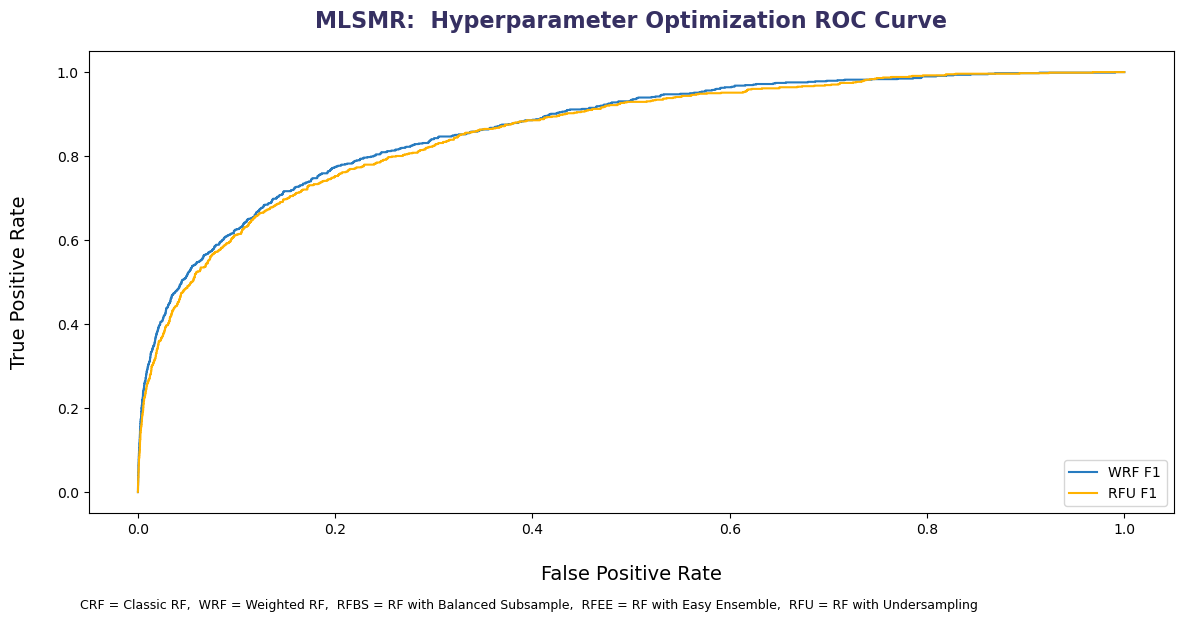

In [21]:
# get auc data and plot
path = f'{data_path}@model/{dir_AUC}/'
metrics=['f1']
df = score.get_auc_data(path, models_topModel, xy_AUC, suffix=suffix, baseline=False, metrics=metrics)

imgfilename = f'{image_path}model{filename_img_auc_topmodels}{suffix}'
title = f'{dataset}:  Hyperparameter Optimization ROC Curve'
score.plot_auc_curve_comparison(df, title, imgfilename, footnote=footnote_models)

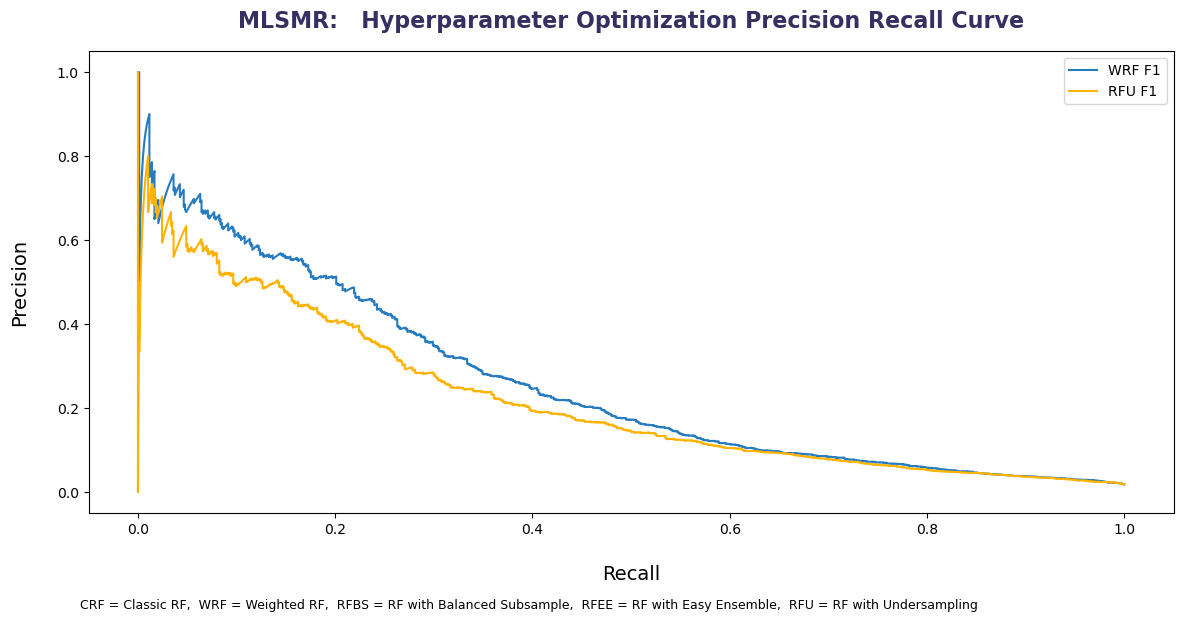

In [22]:
# get precision/recall data and plot
path = f'{data_path}@model/{dir_PrecisionRecall}/'
metrics=['f1']
df = score.get_auc_data(path, models_topModel, xy_PrecisionRecall, suffix=suffix, baseline=False, metrics=metrics)

imgfilename = f'{image_path}model{filename_img_pr_topmodels}{suffix}'
title = f'{dataset}:   Hyperparameter Optimization Precision Recall Curve'
score.plot_recall_curve_comparison(df, title, imgfilename, footnote=footnote_models)

##### &nbsp;&nbsp;&nbsp;20.4 Feature Importance & Model Parameters

In [63]:
cols_topmodels = ['WRF f1 ', 'RFU f1 ']
cols_renamed = {'WRF f1 ': 'Weighted RF - F1', 'RFU f1 ': 'RF w/Undersampling - F1'}
top = '2'

In [64]:
dfFeatureImportance_TopModels = dfFeatureImportance[cols_topmodels]
dfFeatureImportance_TopModels.rename(columns=cols_renamed, inplace=True)

imgfilename = f'{image_path}{filename_img_featureimportance_top}{suffix}'
title = f'{dataset}:  Hyperparameter Optimization<br>Feature Importance<br>Top {top} Models'
score.plot_StyledDataFrame(dfFeatureImportance_TopModels, title, imgfilename)

c:\Users\frogi\anaconda3\envs\tb\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


In [65]:
dfHyperparameters_TopModels = dfHyperparameters[cols_topmodels]
dfHyperparameters_TopModels.rename(columns=cols_renamed, inplace=True)


imgfilename = f'{image_path}{filename_img_hyperparameter_top}{suffix}'
title = f'{dataset}:  Hyperparameter Optimization<br>Best Parameters ~ Top {top} Models'
score.plot_StyledDataFrame(dfHyperparameters_TopModels, title, imgfilename)


c:\Users\frogi\anaconda3\envs\tb\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


##### &nbsp;&nbsp;&nbsp;20.5 tSNE Prediction Representation

ignore\images\WRF\


c:\Users\frogi\anaconda3\envs\tb\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


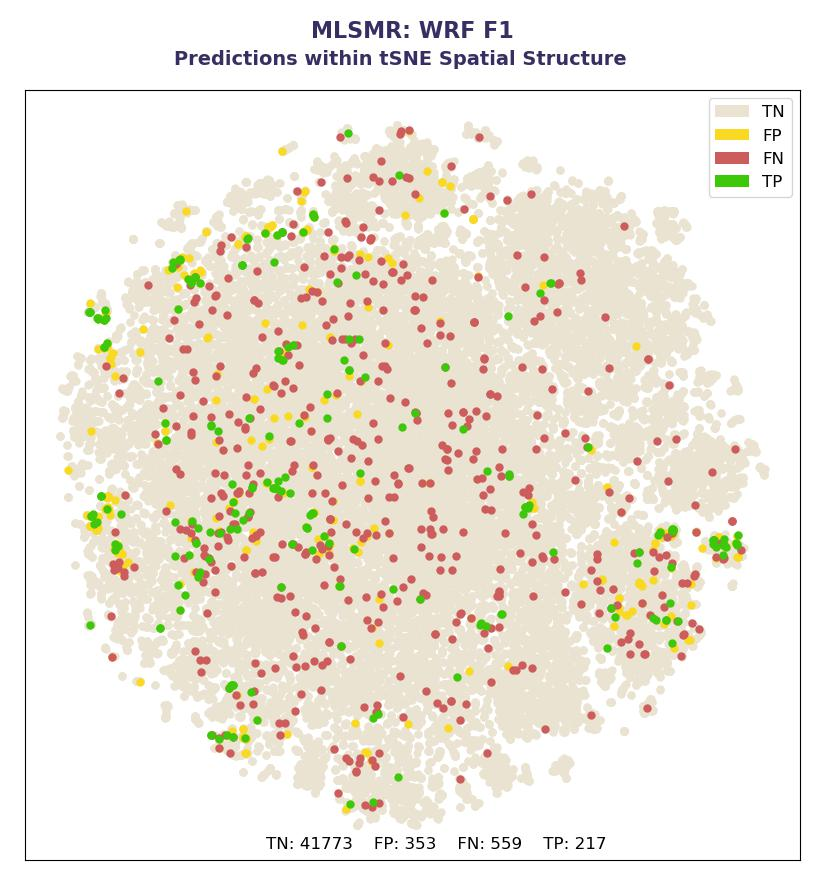

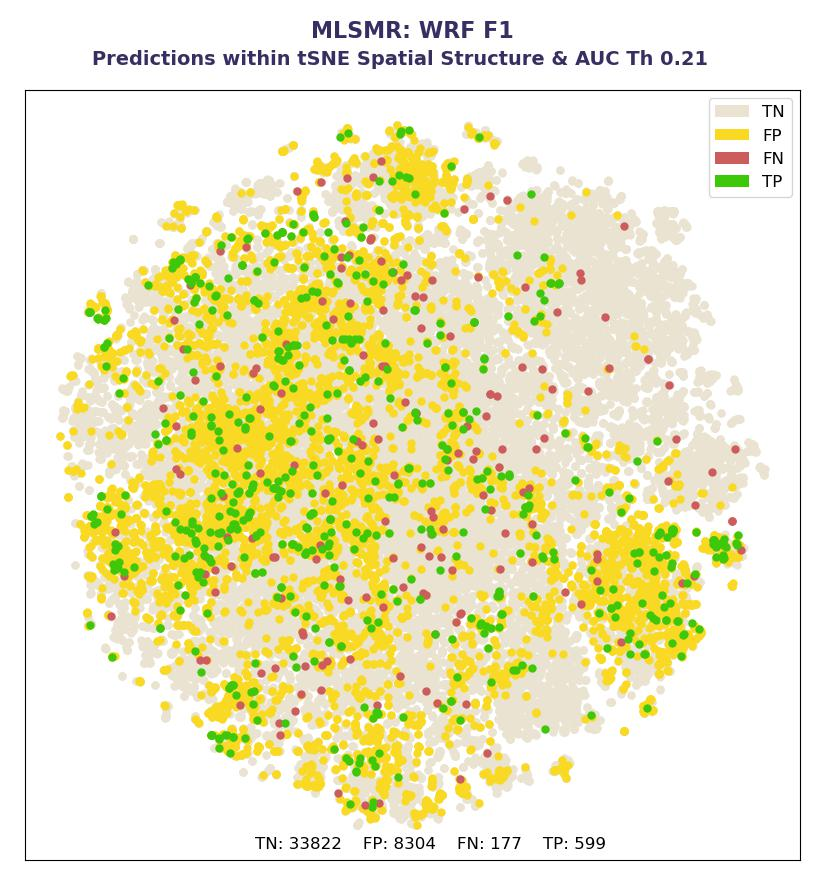

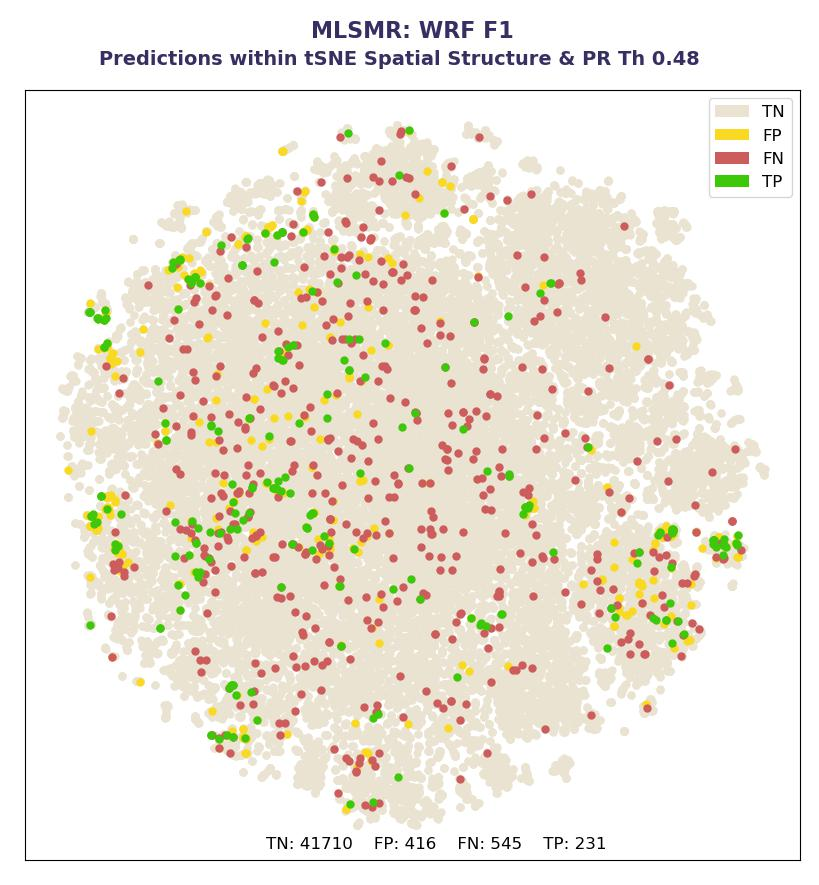

ignore\images\RFU\


c:\Users\frogi\anaconda3\envs\tb\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


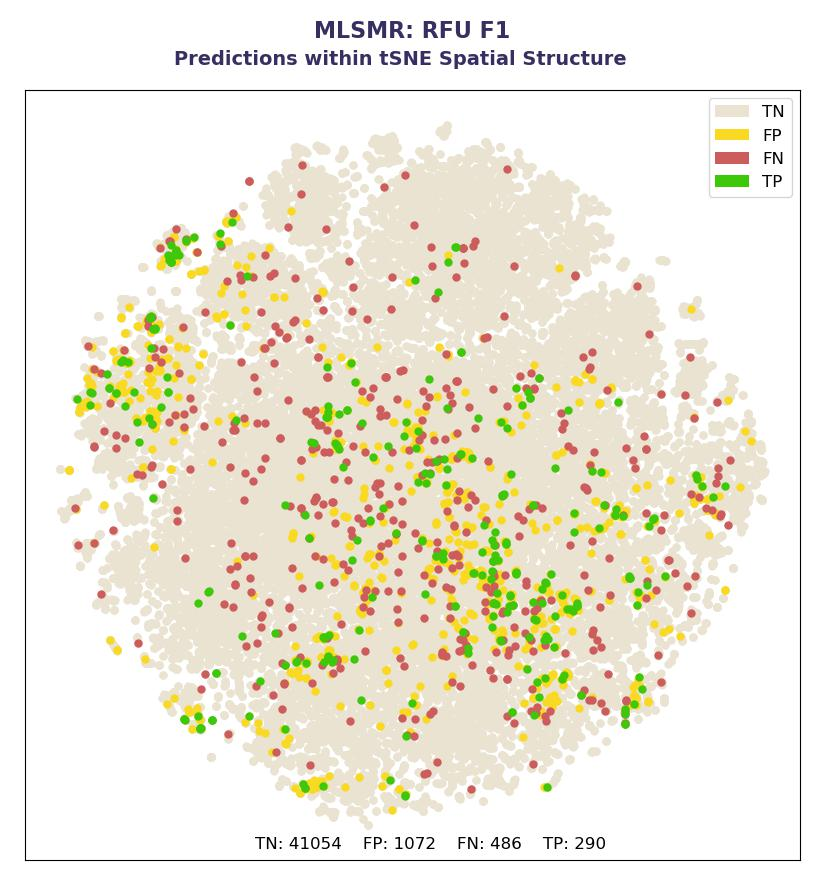

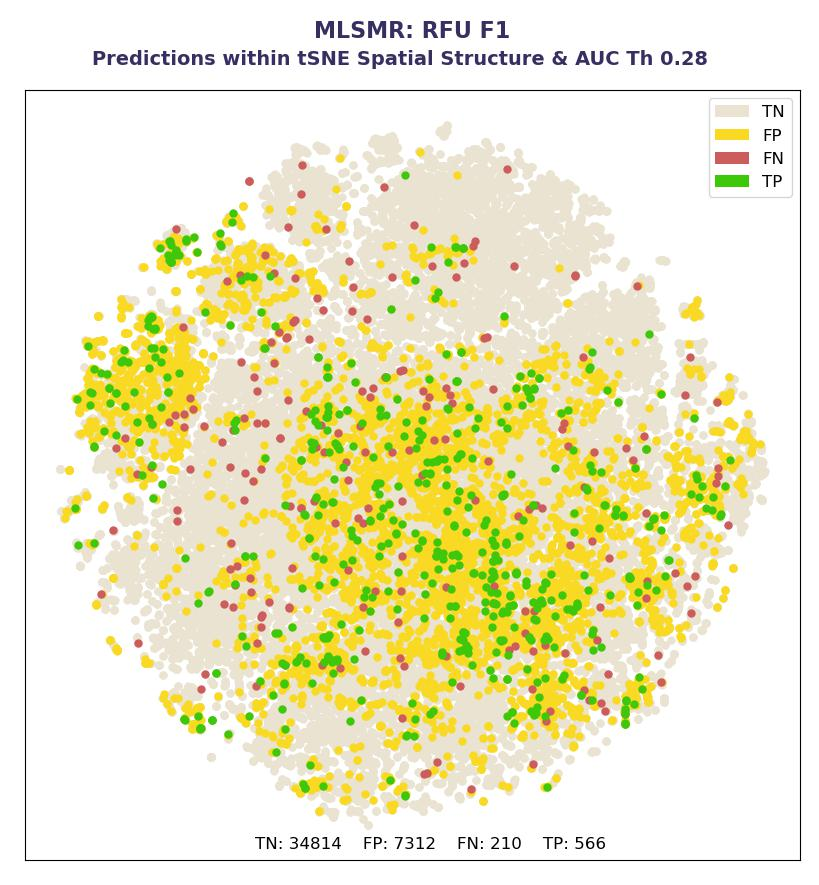

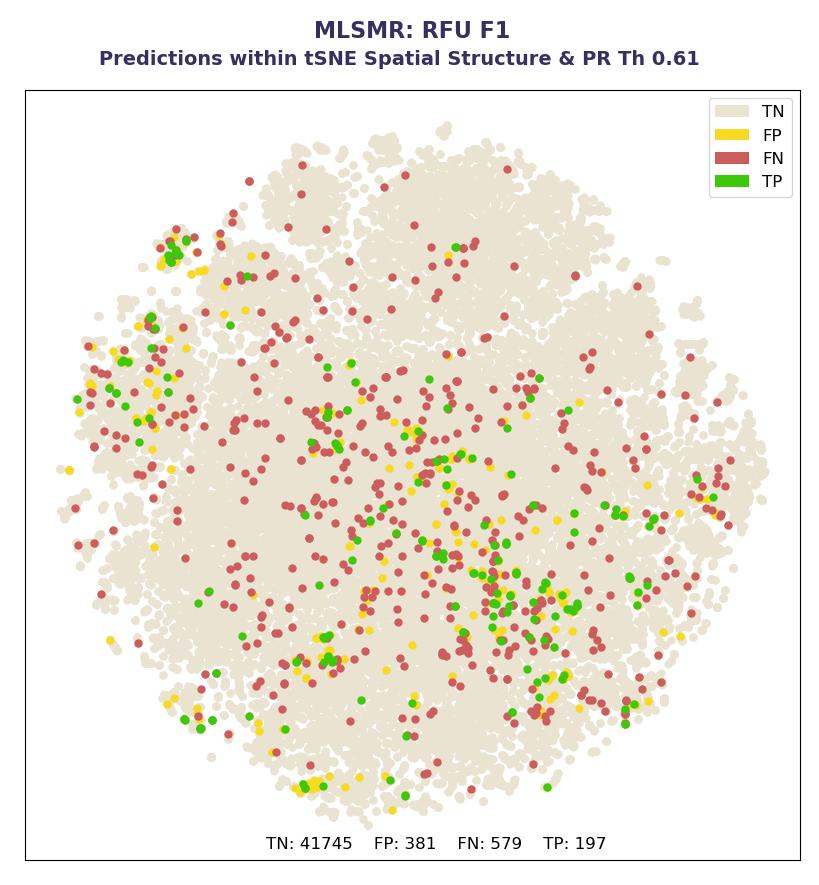

In [117]:
models_top = ['wrf', 'rfu']
models_metric = ['f1', 'f1']
models_th_auc = {'wrf': 0.2119, 'rfu': 0.2817}
models_th_pr = {'wrf': 0.4831, 'rfu': 0.6062}
pc_num = 50
perplexity = 10
getSavedModel = False
subtitle = 'Predictions within tSNE Spatial Structure'


params = {'dataset': dataset,
        'suffix': suffix,
        'models': models_top,
        'metrics': models_metric,
        'thresholds_auc': models_th_auc,
        'thresholds_pr': models_th_pr,
        'x': x_test,
        'x_smiles': x_test_SMILES,
        'y': y_test, 
        'pc_num': pc_num,
        'data_path' : data_path,
        'model_path' : model_path,
        'image_path' : image_path,
        'perplexity': perplexity,       
        'removeticks': True,
        'subtitle': subtitle,
        'getSavedModel': getSavedModel}

score.plot_model_predictions_tsne(**params)

##### &nbsp;&nbsp;&nbsp;20.6 UMAP Prediction Representation

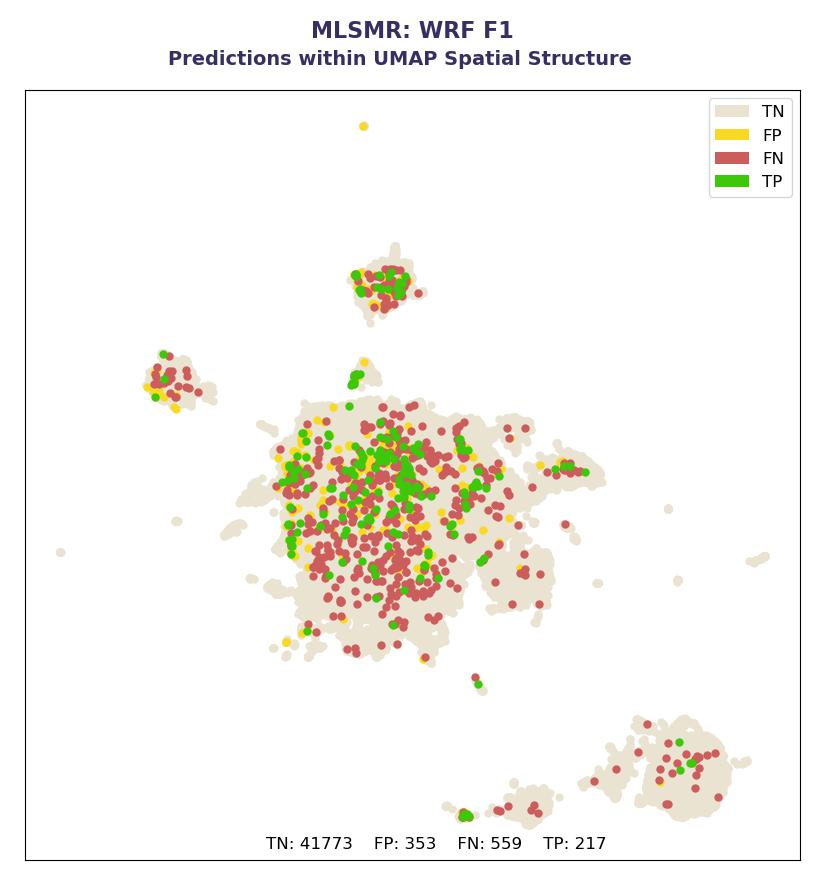

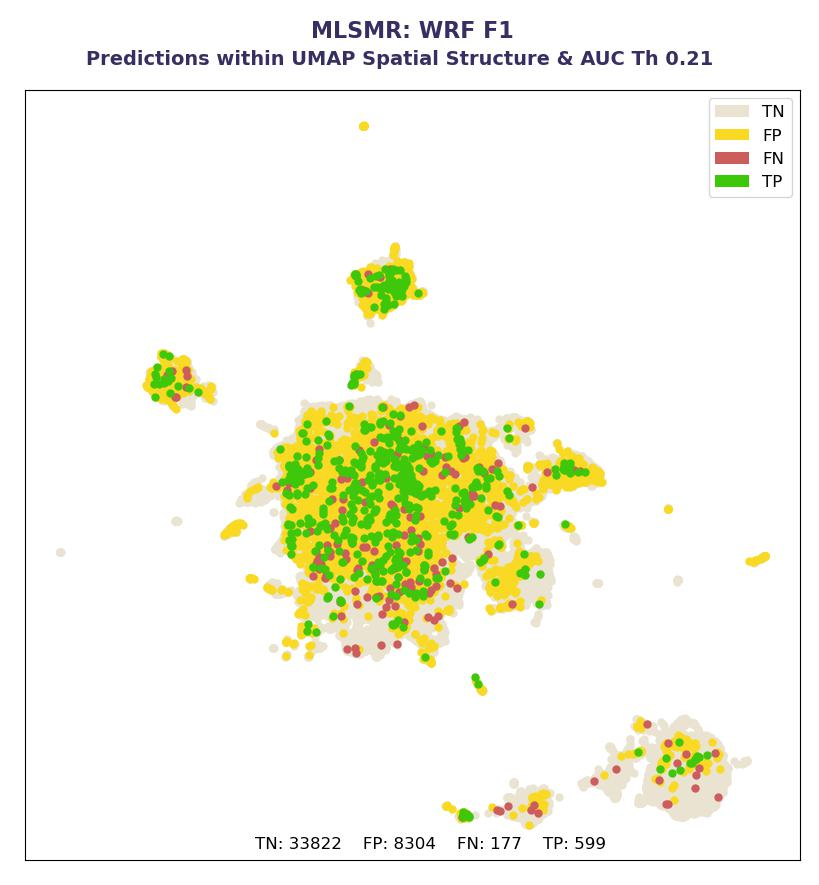

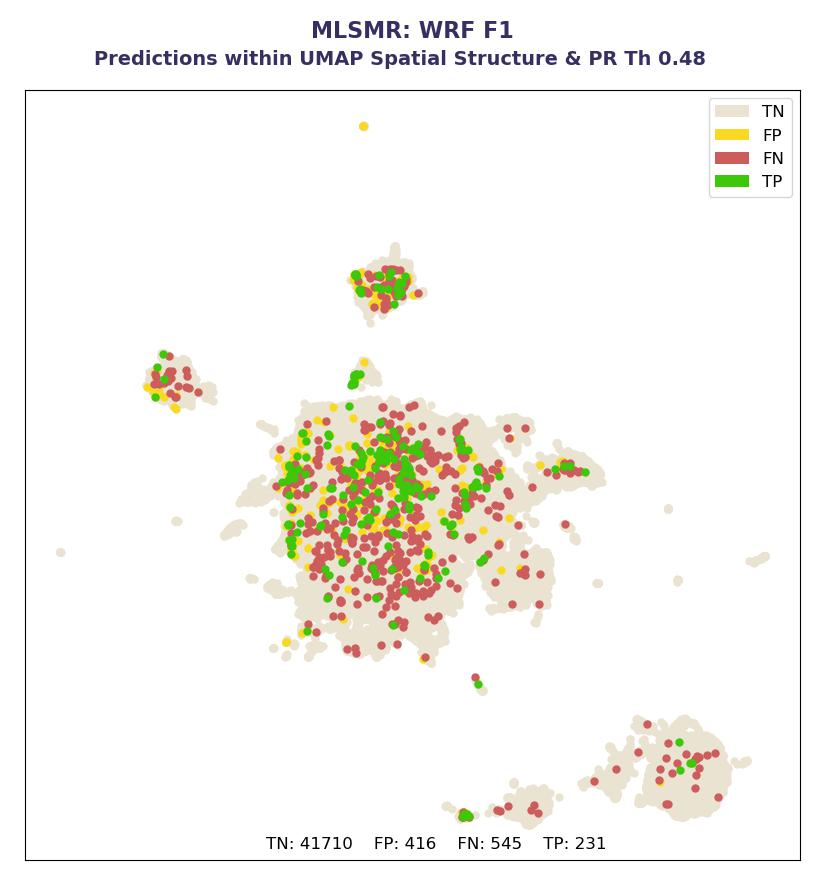

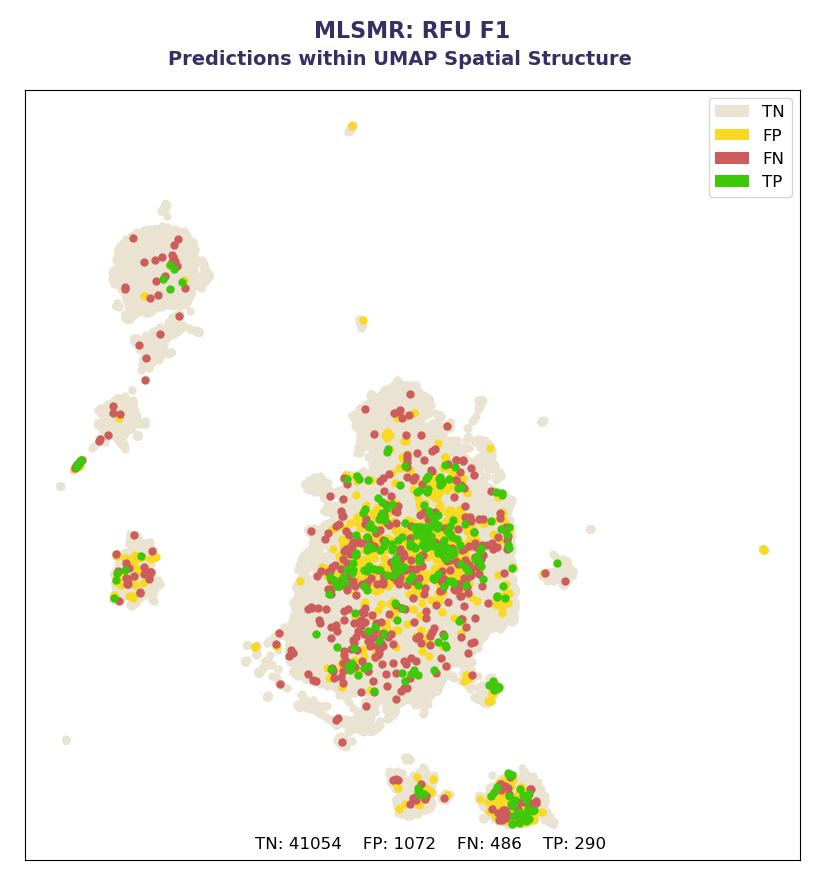

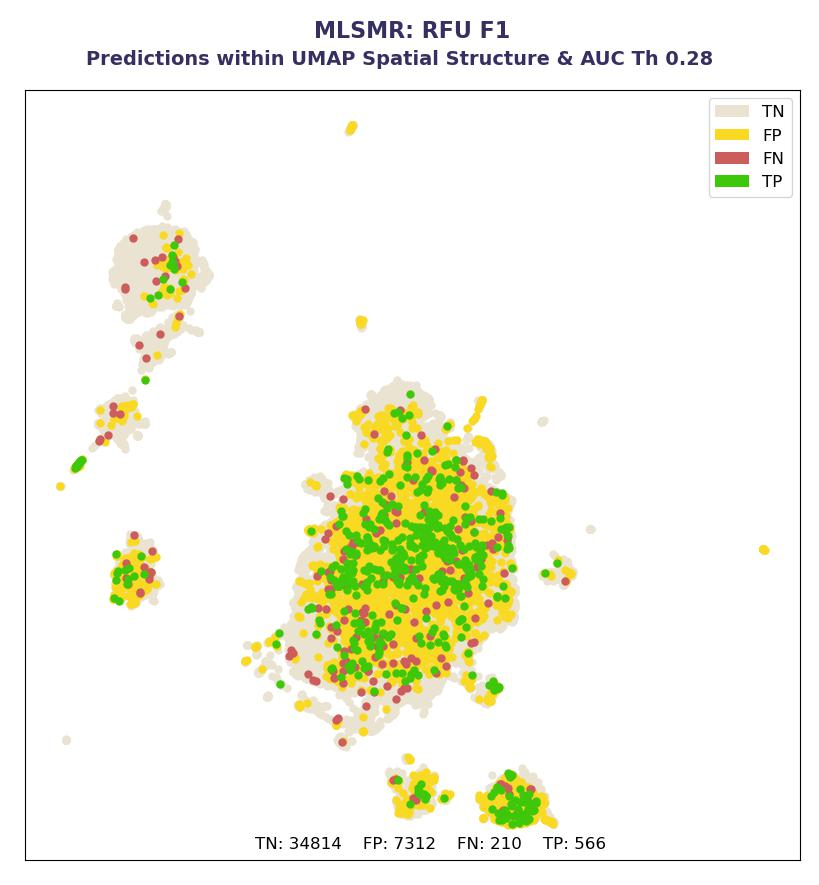

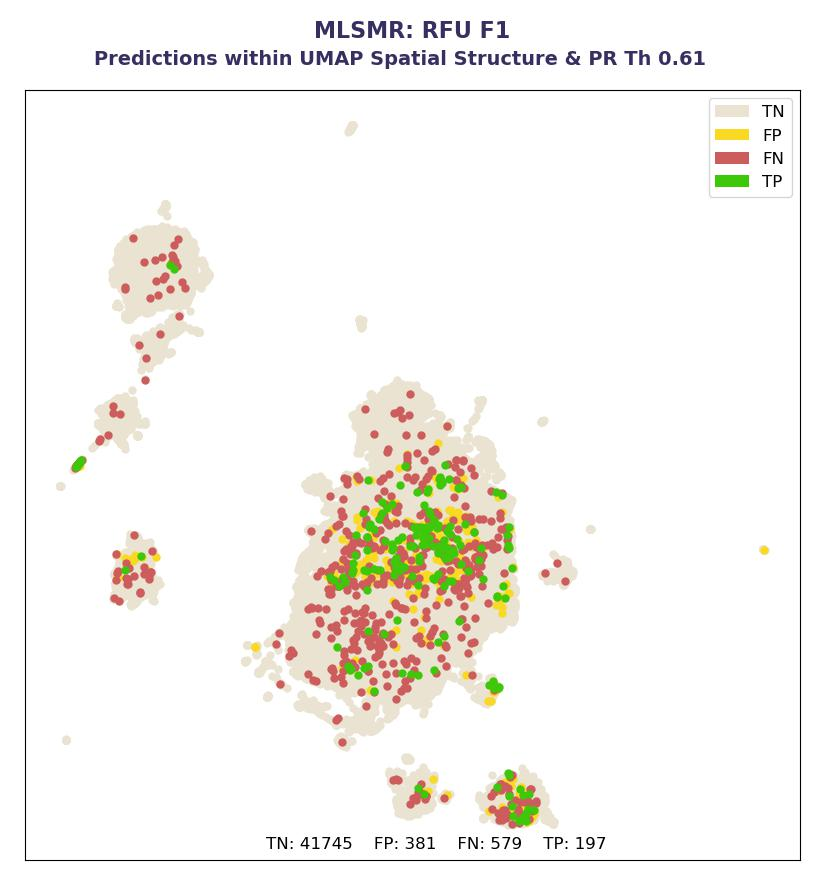

In [130]:
models_top = ['wrf', 'rfu']
models_metric = ['f1', 'f1']
models_th_auc = {'wrf': 0.2119, 'rfu': 0.2817}
models_th_pr = {'wrf': 0.4831, 'rfu': 0.6062}
n_neighbors = 15
min_dist = 0.25
getSavedModel = True
subtitle = 'Predictions within UMAP Spatial Structure'


params = {'dataset': dataset,
        'suffix': suffix,
        'models': models_top,
        'metrics': models_metric,
        'thresholds_auc': models_th_auc,
        'thresholds_pr': models_th_pr,
        'x': x_test,
        'x_smiles': x_test_SMILES,
        'y': y_test, 
        'data_path' : data_path,
        'model_path' : model_path,
        'image_path' : image_path,
        'n_neighbors': n_neighbors,
        'min_dist': min_dist,       
        'subtitle': subtitle,
        'getSavedModel': getSavedModel}

score.plot_model_predictions_umap(**params)

#### 21.  Model Uncertainty & Variance

##### &nbsp;&nbsp;&nbsp; 21.1 Uncertainty Methods

<p style="margin-left: 25px">
    The uncertainty in the model’s prediction for the top-performing models were quantified by generating confidence intervals (CI) using three methods:  train/test splits, bootstrap, and normal approximation.  The following scripts were run in parallel on the cluster, once for each top performing model.  See MethodsEmployed.txt for details and references.  

       - quantify-bootstrap.py
       - quantify-traintestsplit.py
</p>

##### &nbsp;&nbsp;&nbsp;21.2 Load splits with smiles/inhibition

In [4]:
# set filenames
filenames_splitdata = score.get_trainsplits_filenames(data_path, suffix, includeCV=False)

# get splits, with smiles and inhibition for visualization
x_train, y_train, x_test, y_test = score.get_trainsplits(filenames_splitdata)

#for bootstrapping test set
x_test_boot = x_test
y_test_boot = y_test

#remove inhibition and SMILES columns
x_train = x_train.drop(col_NonDescriptors_legacycode, axis=1)
x_test = x_test.drop(col_NonDescriptors_legacycode, axis=1)

##### &nbsp;&nbsp;&nbsp;21.3 Variables

In [96]:
models = ['wrf', 'rfu']
sequences = [1, 2]
metrics = ['f1', 'f1']
graph_trainsplits_yrange = [4, 4]
graph_bootstrap_range = [[0.22, 0.325], [0.225, 0.275]]
graph_bootstrap_bins = [5, 5]
graph_bootstrap_ymax_mean = [300, 300]
graph_bootstrap_ymax_ci = [75, 75]
graph_bootstrap632_range = [[0.3, 0.7], [0.26, 0.57]]
graph_bootstrap632_bins = [5, 5]
graph_bootstrap632_ymax_mean = [300, 300]
graph_bootstrap632_ymax_ci = [75, 75]
graph_normapprox_range = [[0.317, 0.328], [0.266, 0.276]]
graph_ci_range = [[0.21, 0.35], [0.224, 0.278]]
graph_ci_redline_height = [3, 3]

##### &nbsp;&nbsp;&nbsp; 21.4 Model Uncertainty



Model:  WRF
-----------------------------------------------------------------------------------------------


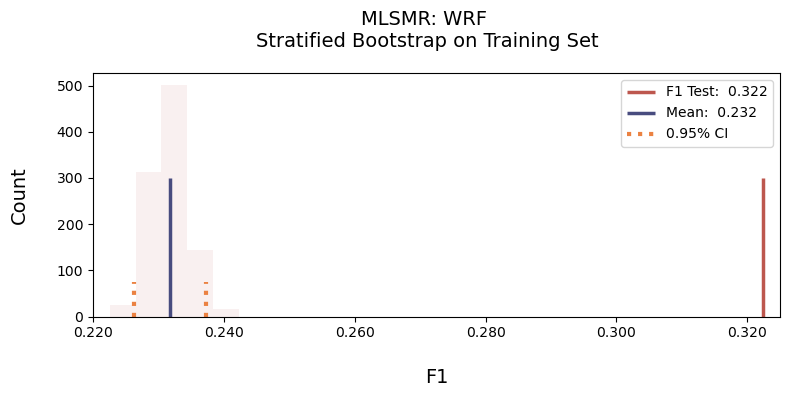

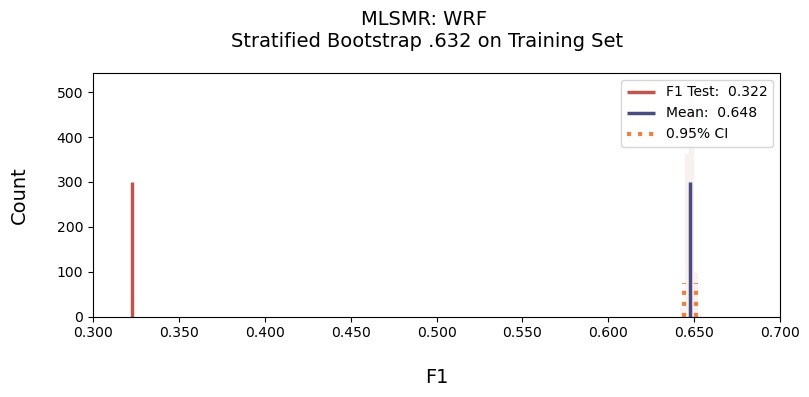

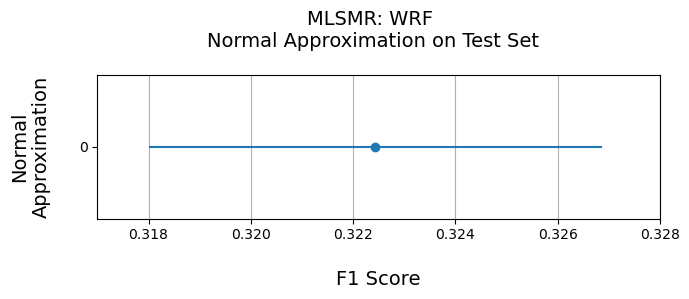

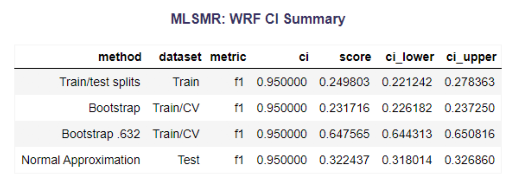

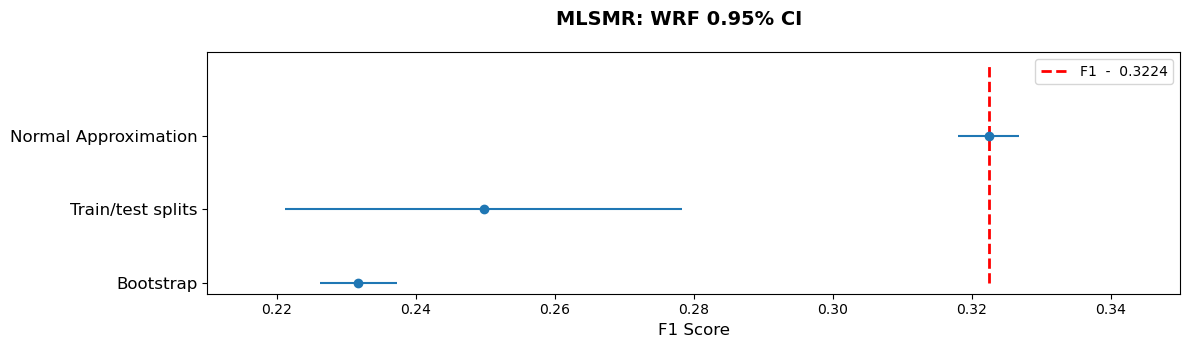

<Figure size 640x480 with 0 Axes>

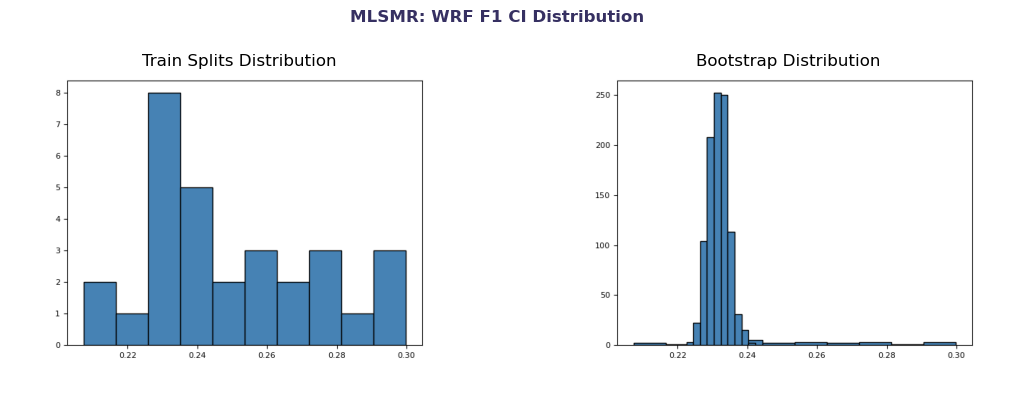

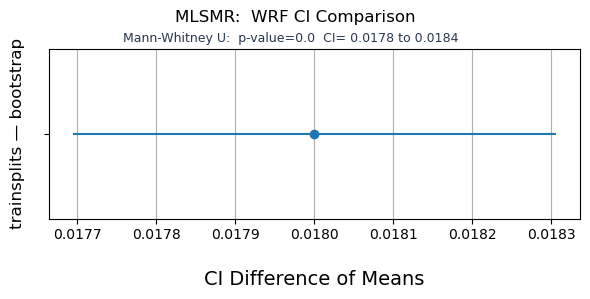

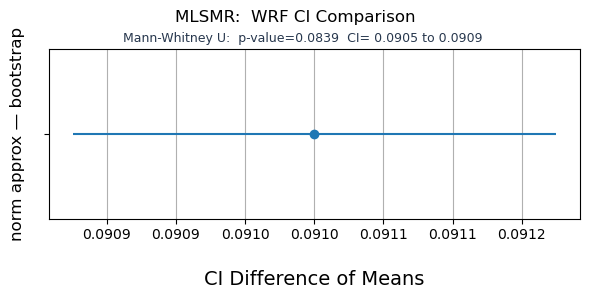

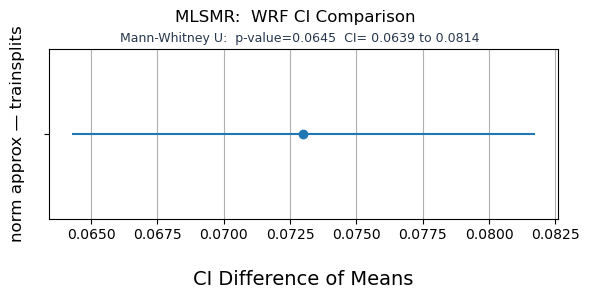



Model:  RFU
-----------------------------------------------------------------------------------------------


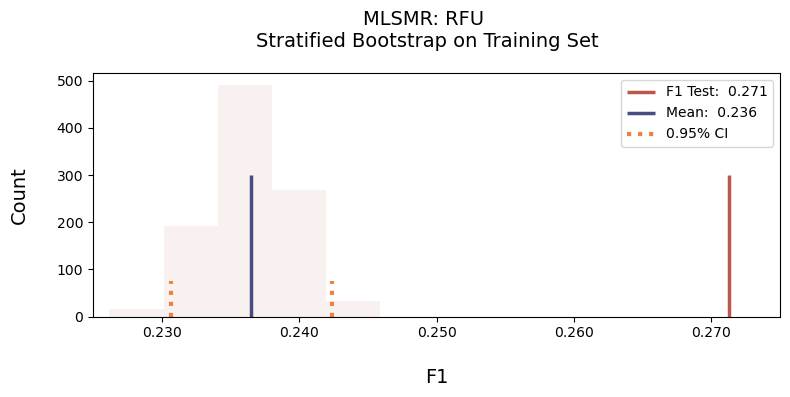

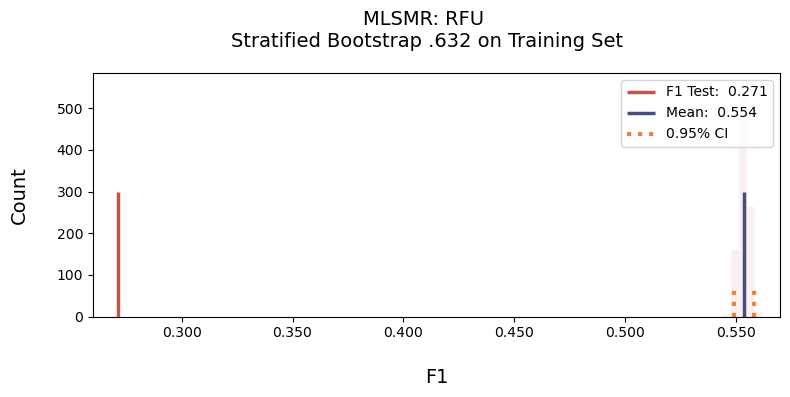

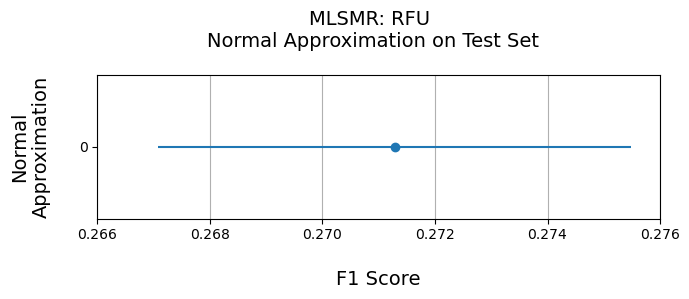

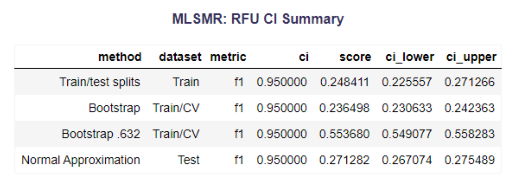

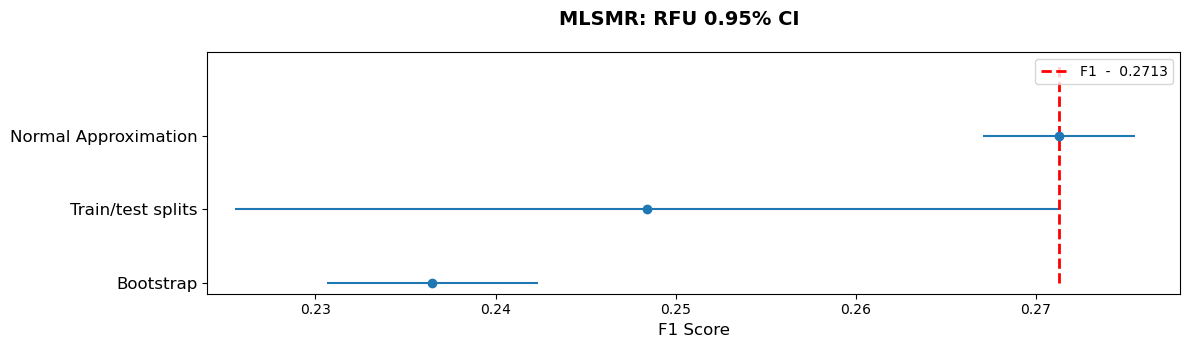

<Figure size 640x480 with 0 Axes>

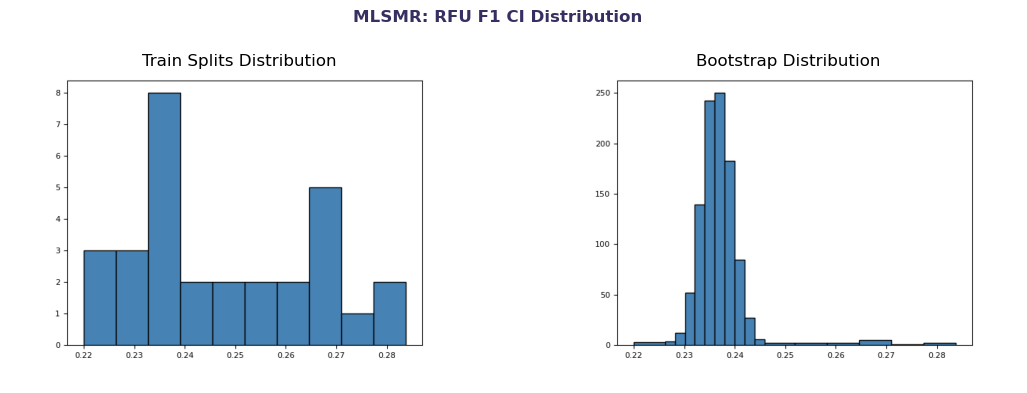

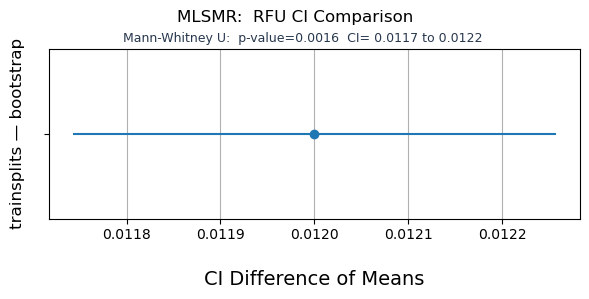

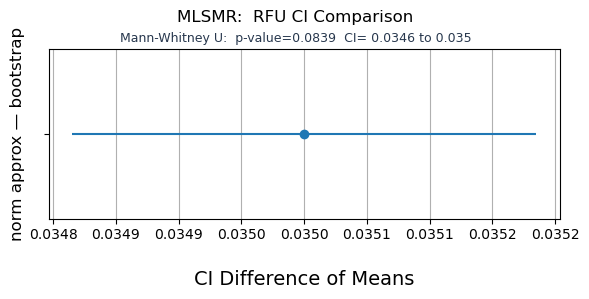

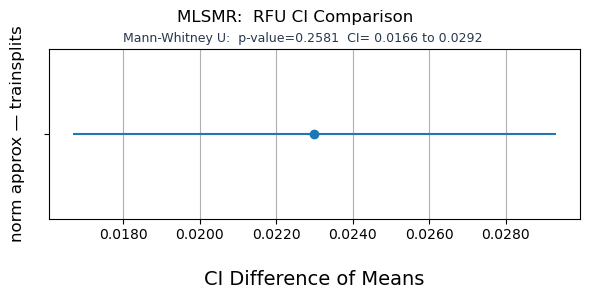



Model Comparison:
-----------------------------------------------------------------------------------------------


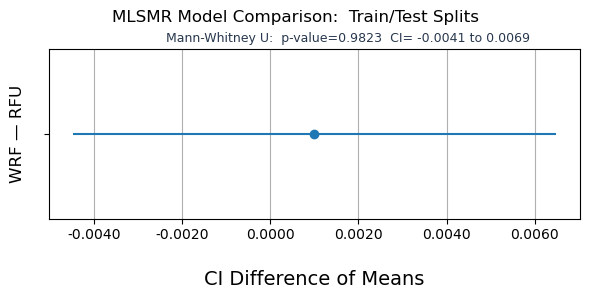

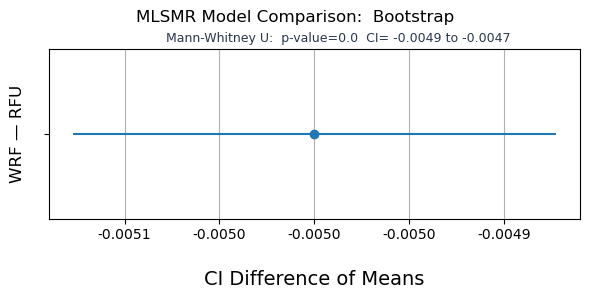

In [114]:
# instantiate optimized models, score and compare
params_ci = {'dataset': dataset,
    'suffix': suffix,
    'models': models,
    'sequences': sequences,
    'metrics': metrics,
    'ci': CI,
    'data_path': data_path,
    'model_path': model_path, 
    'image_path': image_path,
    'x': x_test,
    'y_truth': y_test,
    'graph_trainsplits_yrange': graph_trainsplits_yrange,
    'graph_bootstrap_range': graph_bootstrap_range,
    'graph_bootstrap632_range': graph_bootstrap632_range,
    'graph_bootstrap_bins': graph_bootstrap_bins,
    'graph_bootstrap632_bins': graph_bootstrap632_bins,
    'graph_bootstrap_ymax_mean': graph_bootstrap_ymax_mean,
    'graph_bootstrap632_ymax_mean': graph_bootstrap632_ymax_mean,
    'graph_bootstrap_ymax_ci': graph_bootstrap_ymax_ci,
    'graph_bootstrap632_ymax_ci': graph_bootstrap632_ymax_ci,
    'graph_normapprox_range': graph_normapprox_range,
    'graph_normapprox_range': graph_normapprox_range,
    'graph_ci_range': graph_ci_range,
    'graph_ci_redline_height': graph_ci_redline_height}

quantify.get_model_uncertainty(**params_ci)

#### 22.  Score TAACF-SRIKinase with MLSMR

##### &nbsp;&nbsp;&nbsp;22.1 Load TAACF data

In [68]:
# Dataset was split into 3 separate files:  
# Descriptors_{suffix_TAACF}.csv:  processed unscaled MLSMR data. used for scoring.
# y{suffix_TAACF}.csv:  y labels for data (activity = 1 or 0).  used for tSNE and UMAP, training, scoring.
# Molecules{suffix_TAACF}.csv:  contains SMILES and Inhibition rates.  used for tSNE and UMAP, training, scoring.
score_features = pd.read_csv(f'{data_path}{filename_descriptors_unscaled}{suffix_TAACF}.csv', index_col=0)
score_y = pd.read_csv(f'{data_path}y{suffix_TAACF}.csv', index_col=0)
score_y_true = np.array(score_y['Activity'].tolist())
score_molecules = pd.read_csv(f"{data_path}Molecules{suffix_TAACF}.csv", index_col=0)
score_SMILES = score_molecules[col_NonDescriptors_legacycode].copy()

# add smiles, label, and inhibition 
# this is used to map out the predictions (TP, FP, TN, FN) with tSNE/UMAP
score_mol_y_features = pd.concat([score_molecules[col_NonDescriptors_legacycode], score_y, score_features], axis = 1)

C:\Users\frogi\AppData\Local\Temp\ipykernel_19700\1920030870.py:8: DtypeWarning: Columns (1,5) have mixed types. Specify dtype option on import or set low_memory=False.
  score_molecules = pd.read_csv(f"{data_path}Molecules{suffix_TAACF}.csv", index_col=0)


##### &nbsp;&nbsp;&nbsp;22.2 Scale data

In [73]:
#get data the model was trained on, to retrieve columns 
# set filenames, get splits, and remove inhibition and SMILES columns
filenames_splitdata = score.get_trainsplits_filenames(data_path, suffix_MLSMR, includeCV=False)
x_train, y_train, x_test, y_test = score.get_trainsplits(filenames_splitdata)
x_train = x_train.drop(col_NonDescriptors_legacycode, axis=1)

# get the StandardScaler used when training the model and use it to scale new data
file_scaler = f'{data_path}{filename_scaler}{suffix_MLSMR}.sclr'
score_features_scaled = score.scale_data(score_features, x_train, file_scaler)
#f'{data_path_base}TAACF_Scaled.csv'

##### &nbsp;&nbsp;&nbsp;22.3 Load prior scoring results

In [71]:
GetScores = False
if GetScores:
    dfScores = pd.read_csv(f'{data_path}{filename_model_metrics}{suffix}_scoring{suffix_TAACF}.csv', index_col=0)
dfScores = dfScores.sort_index()

##### &nbsp;&nbsp;&nbsp;22.4 Variables

In [95]:
dataset_scored = 'MLSMR'
models = ['wrf', 'rfu']
metrics=['f1', 'f1']
footnote_models = 'WRF = Weighted RF, RFU = RF with Undersampling'
predict = [True, True]
saveFeatureImportance = [False, False]
saveHyperparameters = [False, False]
saveDecisionTree = [False, False]

titles = [f'{dataset}: Weighted RF Scoring {dataset_scored} Performance'
    , f'{dataset}: RF Undersampling Scoring {dataset_scored} Performance']
groups = [f'Weighted', f'Undersampling']

data_scoring = {'x_test': score_features_scaled,
        'y_test': score_y_true}
scoring_suffix = f'_scoring{suffix_TAACF}'

##### &nbsp;&nbsp;&nbsp;22.5 Score Models

In [82]:
# instantiate optimized models, score and compare
params_score = {'models': models,
    'metrics': metrics,
    'predict': predict,
    'saveFeatureImportance': saveFeatureImportance,
    'saveHyperparameters': saveHyperparameters,
    'saveDecisionTree': saveDecisionTree,
    'titles': titles, 
    'groups': groups,
    'path_model': model_path,
    'path_data': data_path, 
    'path_image': image_path, 
    'suffix': suffix,
    'data_scoring': data_scoring,
    'dfScores': dfScores,
    'scoring_suffix': scoring_suffix}

dfScores, dfFeatureImportance, dfHyperparameters = score.score_models(**params_score)
dfScores.to_csv(f'{data_path}{filename_model_metrics}{suffix}_scoring{suffix_TAACF}.csv')

##### &nbsp;&nbsp;&nbsp;22.6 Model Performance

In [89]:
dfScores_styled = dfScores.copy()
#dfScores_trained_styled.sort_values(by=['Group'])

imgfilename = f'{image_path}{filename_img_metrics}{suffix}{scoring_suffix}'
title = f'{dataset}:  Scoring {dataset_scored} Performance'
hide = ['Group']
score.get_ClassifierScores(dfScores_styled, title, imgfilename, hide=hide, top=2)

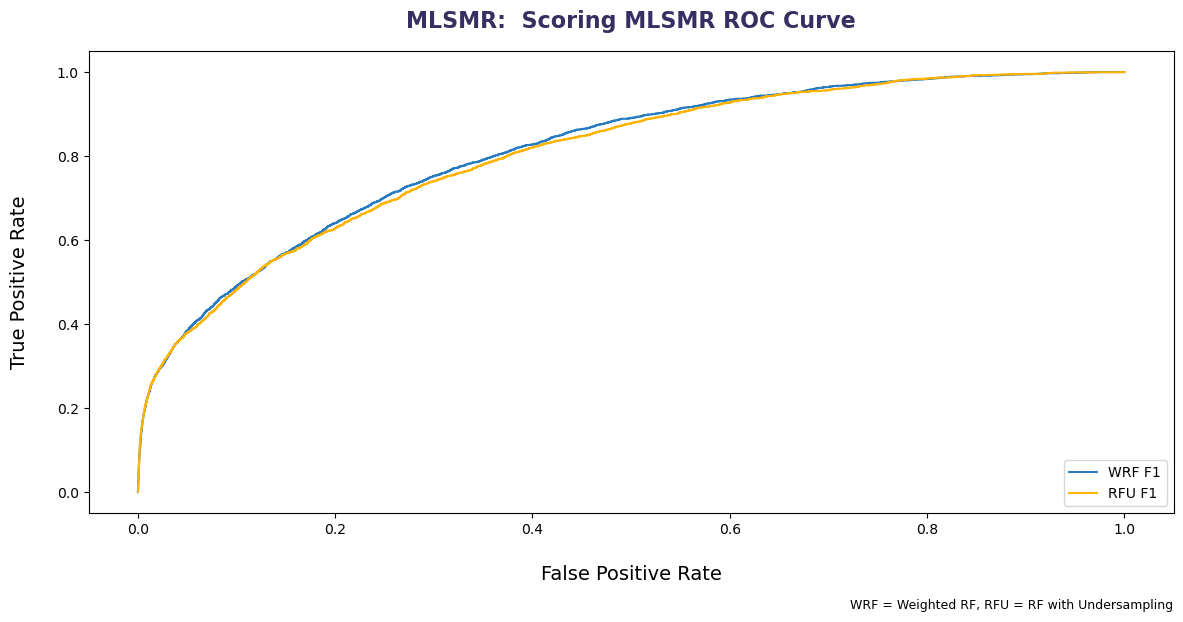

In [111]:
# get auc data and plot
path = f'{data_path}@model/{dir_AUC}/'
metrics=['f1']
df = score.get_auc_data(path, models, xy_AUC, suffix=suffix, baseline=False, metrics=metrics, scoring_suffix=scoring_suffix)

imgfilename = f'{image_path}model{filename_img_auc}{suffix}{scoring_suffix}'
title = f'{dataset}:  Scoring {dataset_scored} ROC Curve'
score.plot_auc_curve_comparison(df, title, imgfilename, footnote=footnote_models, xy=(1, -0.2))

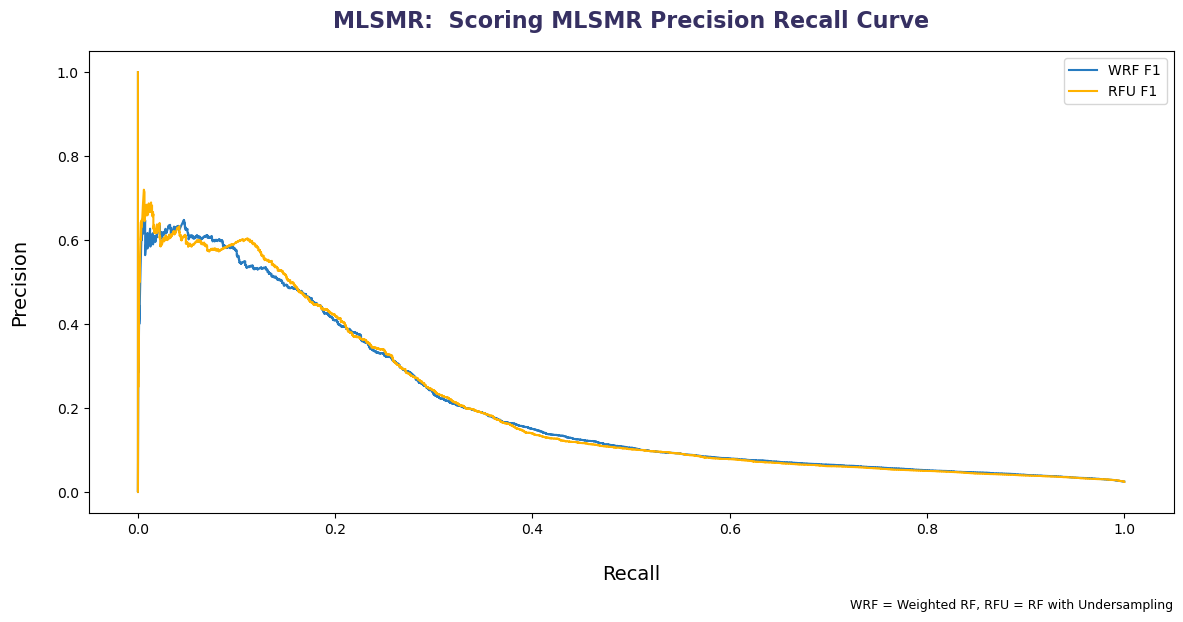

In [114]:
# get precision/recall data and plot
path = f'{data_path}@model/{dir_PrecisionRecall}/'
metrics=['f1']
df = score.get_auc_data(path, models, xy_PrecisionRecall, suffix=suffix, baseline=False, metrics=metrics, scoring_suffix=scoring_suffix)

imgfilename = f'{image_path}model{filename_img_pr}{suffix}{scoring_suffix}'
title = f'{dataset}:  Scoring {dataset_scored} Precision Recall Curve'
score.plot_recall_curve_comparison(df, title, imgfilename, footnote=footnote_models, xy=(1, -0.2))

In [93]:
f'{image_path}model{filename_img_auc}{suffix}{scoring_suffix}'

'ignore\\images\\model_auc_M_scoring_TS'